In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import random as python_random
from collections import Counter
from scipy.spatial import distance
import math
from sklearn.preprocessing import StandardScaler
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv("recidivism.csv")
df.pop('Unnamed: 0')
df.head()

y = df['Recid2Y'].values
df.pop('Recid2Y')
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle = True, random_state=40, stratify = y)
Xtrain_num = X_train[['age','juv_fel_count','juv_misd_count','priors_count']]
x_train_cat = X_train[['Gender','Felony','Caucasian']]
Xtest_num = X_test[['age','juv_fel_count','juv_misd_count','priors_count']]
x_test_cat = X_test[['Gender','Felony','Caucasian']]

stdscl = StandardScaler()
Xtrain_num = stdscl.fit_transform(Xtrain_num)
Xtest_num = stdscl.transform(Xtest_num)

Xtrain = np.hstack((Xtrain_num,x_train_cat))
Xtest = np.hstack((Xtest_num,x_test_cat))

In [16]:
## NN - PSA
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import log_loss

def initialize_network(hidden_size = [5,10,12]):
    W = [np.random.randn(j,i) for i,j in zip(hidden_size[:-1],hidden_size[1:])]
    B = [np.random.randn(i,1) for i in hidden_size[1:]]
    return W,B

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# correct solution:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

def feedforward(X,W,B):
    for weight,biases in zip(W,B):
        X = sigmoid(np.dot(weight,X)+biases)
    return X

def cross_entropy(targets,predictions, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

def underestimation_score_1(y_true,y_pred,SA):

    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',1)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',1)
    

    if P_FX0 == 0:
        print("Divsion by zero detected: denom is ",P_FX0)
        return 0.000001
    print(P_dash_FX0,P_FX0)
    return P_dash_FX0/P_FX0

def underestimation_score(y_true,y_pred,SA):

    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',0)
    if P_FX0 == 0:
        print("Divsion by zero detected: denom is ",P_FX0)
        return 0.000001
    print(P_dash_FX0,P_FX0)
    return P_dash_FX0/P_FX0

def nll1(y_true, y_pred):
    """ Negative log likelihood. """
    y_true = y_true.astype('float32')
    y_pred = y_pred.astype('float32')
    # keras.losses.binary_crossentropy give the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred)), axis=-1)

def UEI(sa, Y_train, Y_pred):
    us_df = {}
    us_df['sa'] = sa
    us_df['ytrain_actual'] = Y_train
    us_df['ytest_pred'] = np.round(Y_pred)
    us_df = pd.DataFrame(us_df)

    prob_array = []
    for y in (0,1):
        for s in (0,1):
#             print((y,s))
            p_tilda = df_count_feat_val_match(us_df, 'ytrain_actual', y, 'sa',s)/len(us_df)
            p_hat = df_count_feat_val_match(us_df, 'ytest_pred', y, 'sa',s)/len(us_df)
#             print(p_hat,p_tilda)
            prob_array.append(   np.square(np.sqrt(p_hat)-np.sqrt(p_tilda))    )
    return np.sqrt(0.5*np.sum(prob_array))

def df_count_feat_val_match(df1, f1, v1, f2, v2):
    return len (df1[(df1[f1]==int(v1)) & (df1[f2]==int(v2))])

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)
    
    ba = nll1(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba.numpy(),us_s

from copy import deepcopy


## initialize var for PSA
states_explored = 0
T_ba = 1000
T_us = 0.01
beta = 0.1
alpha = 0.95
Set_pareto = []
explored = []
pareto_param = []

convergence_ba = collections.deque([-999,-999,-999,-999,-999,-999])
convergence_us = collections.deque([-999,-999,-999,-999,-999,-999])

## generate candidate solution
w,b = initialize_network([Xtrain.shape[1],50,1])
y_hat = feedforward(Xtrain.T,w,b).T
best_ba,best_us = evaluate(y_train,y_hat.ravel(),Xtrain[:,-1])
while T_ba > 0 and T_us > 0:

    N_success = 0
    N_trials = 0
#     pbar = tqdm(total=1000)

    while N_success < 1000 and N_trials < 10000:

        ## generate candidate solutions
#         updates = np.zeros(X_train.shape[1]+1)
#         updates[np.random.choice(np.arange(len(updates)))] = np.random.normal(0, 1, 1)
#         w_candidate = w + updates[:X_train.shape[1]] * beta
#         b_candidate = b + updates[-1] * beta
        
        states_explored += 1
        w_candidate = deepcopy(w)
        b_candidate = deepcopy(b)
        
        layer_index = int(np.random.choice(np.arange(len(w_candidate)),size=1))
        indices = int(np.random.choice(np.arange(w_candidate[layer_index].size+1), replace=False,size=1))
#         print(layer_index,indices,w_candidate[layer_index].size)
        if indices < w_candidate[layer_index].size:
            w_candidate[layer_index].ravel()[indices-1] += np.random.normal(0, 3, 1) * beta
#             print(w_candidate[layer_index].ravel()[indices-1],w[layer_index].ravel()[indices-1])
#             print(w_candidate[layer_index].shape)
#             w_candidate[layer_index].reshape(w[layer_index].shape)
        else:
            b_indices = int(np.random.choice(np.arange(b_candidate[layer_index].size), replace=False,size=1))
            b_candidate[layer_index][b_indices] += np.random.normal(0, 3, 1)  * beta
        
        
        y_hat = feedforward(Xtrain.T,w_candidate,b_candidate).T
        candidate_ba,candidate_us = evaluate(y_train,y_hat.ravel(),Xtrain[:,-1])
#         print(candidate_ba)
        delta_E_ba = (best_ba - candidate_ba)
        delta_E_us = (best_us - candidate_us)
#         print(delta_E_ba,delta_E_us)
        if ((delta_E_ba > 0) and (delta_E_us > 0)):

            w = w_candidate
            b = b_candidate
            best_ba = candidate_ba
            best_us = candidate_us
            N_success += 1
#             pbar.update(1)
            Set_pareto.append((best_ba,best_us))
            explored.append((best_ba,best_us))
            pareto_param.append((w,b))
        else:
            prob_us = abs(delta_E_us) / T_us
            prob_ba = abs(delta_E_ba)/T_ba
            delta_E = prob_ba + prob_us
            accept_prob = min(1,np.exp(-delta_E))
            if accept_prob > np.random.rand():
                w = w_candidate
                b = b_candidate
                best_ba = candidate_ba
                best_us = candidate_us
                Set_pareto.append((best_ba,best_us))
                explored.append((best_ba,best_us))
                pareto_param.append((w,b))
                N_success += 1
#                 pbar.update(1)
            else:
                N_trials += 1 
                explored.append((best_ba,best_us))
#     pbar.close()

    if np.round(np.mean(convergence_ba),decimals=15) == np.round(best_ba,decimals=15) and np.round(np.mean(convergence_us),decimals=15) == np.round(best_us,decimals=15):
        break
    else:
        convergence_ba.popleft()
        convergence_us.popleft()
        convergence_ba.append(best_ba)
        convergence_us.append(best_us)
        T_ba = T_ba * alpha
        T_us = T_us * alpha

        print("Temp_ba: {}, Temp_US: {}".format(T_ba,T_us))
        print("Best ba  :   {}".format(best_ba/Xtrain.shape[0]))
        
        print("Best us:   {}".format(best_us))
        print("Success #:   {}".format(N_success))
        print("Trials  #:   {}".format(N_trials))
        print("states_explored:",states_explored)
#     print("Coef     :   {}".format(w))
#     print("Intercept:   {}".format(b))
    print("\n")

Temp_ba: 950.0, Temp_US: 0.0095
Best ba  :   0.7581649541524311
Best us:   0.010056681932163143
Success #:   1000
Trials  #:   289
states_explored: 1289


Temp_ba: 902.5, Temp_US: 0.009025
Best ba  :   0.7358402305840266
Best us:   0.0014618566126608726
Success #:   1000
Trials  #:   335
states_explored: 2624


Temp_ba: 857.375, Temp_US: 0.00857375
Best ba  :   0.7050273046797633
Best us:   0.00456377569820238
Success #:   1000
Trials  #:   428
states_explored: 4052


Temp_ba: 814.5062499999999, Temp_US: 0.0081450625
Best ba  :   0.8184337438416023
Best us:   0.05912982696813655
Success #:   1000
Trials  #:   536
states_explored: 5588


Temp_ba: 773.7809374999998, Temp_US: 0.007737809374999999
Best ba  :   0.8421743283013963
Best us:   0.02596988882509162
Success #:   1000
Trials  #:   402
states_explored: 6990


Temp_ba: 735.0918906249998, Temp_US: 0.007350918906249998
Best ba  :   0.713410433223163
Best us:   0.016714629374370227
Success #:   1000
Trials  #:   454
states_explored: 84

Temp_ba: 89.74483193085074, Temp_US: 0.0008974483193085071
Best ba  :   0.7310635073158052
Best us:   0.002400787091802967
Success #:   1000
Trials  #:   1539
states_explored: 93524


Temp_ba: 85.25759033430819, Temp_US: 0.0008525759033430817
Best ba  :   0.7263560273383344
Best us:   0.006039959342444356
Success #:   1000
Trials  #:   1634
states_explored: 96158


Temp_ba: 80.99471081759278, Temp_US: 0.0008099471081759276
Best ba  :   0.7220881842320261
Best us:   0.0017852335478539057
Success #:   1000
Trials  #:   1705
states_explored: 98863


Temp_ba: 76.94497527671314, Temp_US: 0.0007694497527671312
Best ba  :   0.696766077208977
Best us:   0.0008089273587777718
Success #:   1000
Trials  #:   1643
states_explored: 101506


Temp_ba: 73.09772651287747, Temp_US: 0.0007309772651287747
Best ba  :   0.6983380739843286
Best us:   0.0023655663583013234
Success #:   1000
Trials  #:   1807
states_explored: 104313


Temp_ba: 69.4428401872336, Temp_US: 0.0006944284018723359
Best ba  :   0.692

Temp_ba: 8.924249150467196, Temp_US: 8.924249150467197e-05
Best ba  :   0.6435516895362943
Best us:   0.0
Success #:   1000
Trials  #:   5027
states_explored: 286011


Temp_ba: 8.478036692943835, Temp_US: 8.478036692943837e-05
Best ba  :   0.6404279080634779
Best us:   0.0005734487289706611
Success #:   1000
Trials  #:   4726
states_explored: 291737


Temp_ba: 8.054134858296642, Temp_US: 8.054134858296645e-05
Best ba  :   0.6407596182412358
Best us:   0.0
Success #:   1000
Trials  #:   5079
states_explored: 297816


Temp_ba: 7.65142811538181, Temp_US: 7.651428115381812e-05
Best ba  :   0.6437976192686671
Best us:   0.000173006483228572
Success #:   1000
Trials  #:   4952
states_explored: 303768


Temp_ba: 7.268856709612719, Temp_US: 7.268856709612721e-05
Best ba  :   0.6469908858035007
Best us:   0.0
Success #:   1000
Trials  #:   4859
states_explored: 309627


Temp_ba: 6.9054138741320825, Temp_US: 6.905413874132085e-05
Best ba  :   0.6460875799972767
Best us:   0.0002989849886264073
S

Temp_ba: 0.76085997811183, Temp_US: 7.6085997811183e-06
Best ba  :   0.6534242257903793
Best us:   0.0
Success #:   1000
Trials  #:   6401
states_explored: 611346


Temp_ba: 0.7228169792062386, Temp_US: 7.228169792062385e-06
Best ba  :   0.6533161540342147
Best us:   0.0
Success #:   1000
Trials  #:   6224
states_explored: 618570


Temp_ba: 0.6866761302459266, Temp_US: 6.866761302459265e-06
Best ba  :   0.6525410837077886
Best us:   0.0
Success #:   1000
Trials  #:   6259
states_explored: 625829


Temp_ba: 0.6523423237336302, Temp_US: 6.523423237336301e-06
Best ba  :   0.6542269547497029
Best us:   0.0
Success #:   1000
Trials  #:   5678
states_explored: 632507


Temp_ba: 0.6197252075469487, Temp_US: 6.197252075469486e-06
Best ba  :   0.6568168569116409
Best us:   0.0
Success #:   1000
Trials  #:   6145
states_explored: 639652


Temp_ba: 0.5887389471696013, Temp_US: 5.887389471696011e-06
Best ba  :   0.6567082532586899
Best us:   0.0
Success #:   1000
Trials  #:   6035
states_explored:

KeyboardInterrupt: 

In [17]:
def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]
    
def filter_Pareto(Set_pareto,pareto_param):
    pareto_array = np.array(Set_pareto)
    inverser = lambda t: 1/(t+0.000000001)
    pareto_array[:,1] = [inverser(x) for x in pareto_array[:,1]]
    pareto_array[:,0] = [inverser(x) for x in pareto_array[:,0]]
    pareto_index = identify_pareto(pareto_array)

    #pareto filtered
    pareto_ba = [Set_pareto[idx][0] for idx in pareto_index]
    pareto_us = [Set_pareto[idx][1] for idx in pareto_index]
    pareto_w = [pareto_param[idx][0] for idx in pareto_index]
    pareto_b = [pareto_param[idx][1] for idx in pareto_index]

    return pareto_ba,pareto_us,pareto_w,pareto_b

pareto_ba,pareto_us,pareto_w,pareto_b = filter_Pareto(Set_pareto,pareto_param)

In [18]:
temp = []
for x,y  in zip(pareto_ba,pareto_us):
    temp.append((x,y))
print("Pareto   :   {}".format(temp))

Pareto   :   [(3199.037, 0.0), (3195.4463, 0.000173006483228572), (3194.9885, 0.00029893801685951536), (3195.1802, 0.00024378468037618818), (3194.3567, 0.0005734081343813152), (3195.4326, 0.00017301146649219428)]


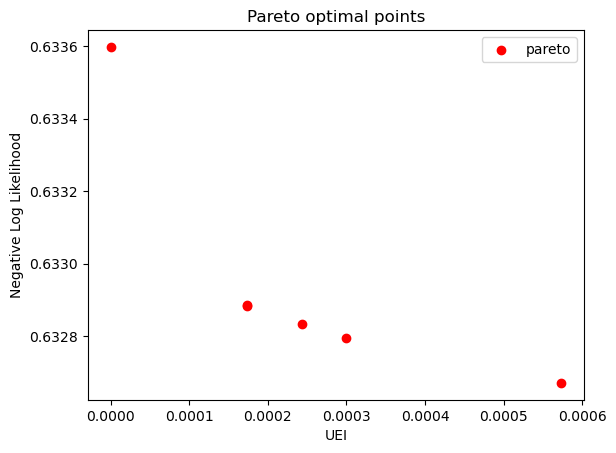

In [19]:
plt.title("Pareto optimal points")
# plt.scatter(non_pareto_us,non_pareto_ba,color='blue')
pareto_ba_normalized  = [ba/Xtrain.shape[0] for ba in pareto_ba]
plt.scatter(pareto_us,pareto_ba_normalized,color='red',label="pareto")
plt.ylabel("Negative Log Likelihood")
plt.xlabel("UEI")
plt.legend()

In [20]:
def feedforward_eval(X,W,B):
    for weight,biases in zip(W,B):
        X = sigmoid(np.dot(weight,X)+biases)
    return X

w_final = np.array(pareto_w[np.argmin(pareto_us)])
b_final = pareto_b[np.argmin(pareto_us)]
y_hat = feedforward(Xtrain.T,w_final,b_final).T
best_ba,best_us = evaluate(y_train,y_hat.ravel(),Xtrain[:,-1])
print("Train: ",best_ba/Xtrain.shape[0],best_us)
y_prob_lowuei = feedforward(Xtest.T,w_final,b_final).T
# y_prob_lowuei = feedforward(Xtest.T,w_final,b_final).T
print("Acc: ",accuracy_score(y_test,np.round(y_prob_lowuei)))
best_ba,best_us = evaluate(y_test,y_prob_lowuei.ravel(),Xtest[:,-1])
print("Test: ",best_ba/Xtest.shape[0],best_us)

print("US_S_0")
print(underestimation_score(y_test,np.round(y_prob_lowuei).ravel(),Xtest[:,-1]))
print("US_S_1")
print(underestimation_score_1(y_test,np.round(y_prob_lowuei).ravel(),Xtest[:,-1]))



Train:  0.6335981599079026 0.0
Acc:  0.6554272517321016
Test:  0.6644030000541282 0.008528943541779875
US_S_0
694 706
0.9830028328611898
US_S_1
258 270
0.9555555555555556


In [34]:
import pickle
with open('recid_run3.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([pareto_ba,pareto_us,pareto_w,pareto_b,y_prob_lowuei], f)

In [13]:
# def get_ece(predicted_posterior, predicted_label, true_label, R):
#     bin_size = 1/R
#     total_sample = len(true_label)
#     K = predicted_posterior.shape[1]

#     score = 0
#     # K is the number of class labels
#     for k in range(K):
#         posteriors = predicted_posterior[:,k]
#         sorted_indx = np.argsort(posteriors)
#         for r in range(R):        
#             indx = sorted_indx[r*R:(r+1)*R]
#             predicted_label_ = predicted_label[indx]
#             true_label_ = true_label[indx]

#             indx_k = np.where(true_label_ == k)[0]
#             acc = (
#                 np.nan_to_num(np.mean(predicted_label[indx_k] == k))
#                 if indx_k.size != 0
#                 else 0
#             )
#             conf = np.nan_to_num(np.mean(posteriors[indx_k])) if indx_k.size != 0 else 0
#             score += len(indx) * np.abs(acc - conf)

#     score /= (K*total_sample)
#     return score

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Run1'] = y_prob_lowuei.ravel()
df = pd.DataFrame(df)

print("ECE overall:")
# print(get_ece(df['Run1'].values.reshape(-1,1), np.round(df['Run1'].values.reshape(-1,1)), np.array(y_test), R=100))

minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
print("ECE majority:")
print(get_ece(majority['Run1'].values.reshape(-1,1), np.round(majority['Run1'].values.reshape(-1,1)), np.array(majority.actual), R=100))
print("ECE minority:")
print(get_ece(minority['Run1'].values.reshape(-1,1), np.round(minority['Run1'].values.reshape(-1,1)), np.array(minority.actual), R=100))

ECE overall:
ECE majority:


NameError: name 'get_ece' is not defined

In [21]:
print(compute_calibration_error(np.array(df.actual),df['Run1'].values,n_bins=5))
print(compute_calibration_error(np.array(majority.actual),majority['Run1'].values,n_bins=5))
print(compute_calibration_error(np.array(minority.actual),minority['Run1'].values,n_bins=5))

0.0417
0.0419
0.0855


In [9]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from typing import Dict, List, Tuple, Optional
from sklearn.utils import check_consistent_length, column_or_1d
from sklearn.calibration import calibration_curve


__all__ = [
    'compute_calibration_error',
    'create_binned_data',
    'get_bin_boundaries',
    'compute_binary_score',
    'compute_calibration_summary',
]


def compute_calibration_error(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int=15,
    round_digits: int=4) -> float:
    """
    Computes the calibration error for binary classification via binning
    data points into the specified number of bins. Samples with similar
    ``y_prob`` will be grouped into the same bin. The bin boundary is
    determined by having similar number of samples within each bin.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    n_bins : int, default 15
        A bigger bin number requires more data. In general,
        the larger the bin size, the closer the calibration error
        will be to the true calibration error.

    round_digits : int, default 4
        Round the calibration error metric.

    Returns
    -------
    calibration_error : float
        RMSE between the average positive label and predicted probability
        within each bin.
    """
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)
    check_consistent_length(y_true, y_prob)

    binned_y_true, binned_y_prob = create_binned_data(y_true, y_prob, n_bins)

    # looping shouldn't be a source of bottleneck as n_bins should be a small number.
    bin_errors = 0.0
    for bin_y_true, bin_y_prob in zip(binned_y_true, binned_y_prob):
        avg_y_true = np.mean(bin_y_true)
        avg_y_score = np.mean(bin_y_prob)
        bin_error = (avg_y_score - avg_y_true) ** 2
        bin_errors += bin_error * len(bin_y_true)

    calibration_error = math.sqrt(bin_errors / len(y_true))
    return round(calibration_error, round_digits)


def create_binned_data(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Bin ``y_true`` and ``y_prob`` by distribution of the data.
    i.e. each bin will contain approximately an equal number of
    data points. Bins are sorted based on ascending order of ``y_prob``.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    n_bins : int, default 15
        A bigger bin number requires more data.

    Returns
    -------
    binned_y_true/binned_y_prob : 1d ndarray
        Each element in the list stores the data for that bin.
    """
    sorted_indices = np.argsort(y_prob)
    sorted_y_true = y_true[sorted_indices]
    sorted_y_prob = y_prob[sorted_indices]
    binned_y_true = np.array_split(sorted_y_true, n_bins)
    binned_y_prob = np.array_split(sorted_y_prob, n_bins)
    return binned_y_true, binned_y_prob


def get_bin_boundaries(binned_y_prob: List[np.ndarray]) -> np.ndarray:
    """
    Given ``binned_y_prob`` from ``create_binned_data`` get the
    boundaries for each bin.

    Parameters
    ----------
    binned_y_prob : list
        Each element in the list stores the data for that bin.

    Returns
    -------
    bins : 1d ndarray
        Boundaries for each bin.
    """
    bins = []
    for i in range(len(binned_y_prob) - 1):
        last_prob = binned_y_prob[i][-1]
        next_first_prob = binned_y_prob[i + 1][0]
        bins.append((last_prob + next_first_prob) / 2.0)

    bins.append(1.0)
    return np.array(bins)


def compute_binary_score(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    round_digits: int=4) -> Dict[str, float]:
    """
    Compute various evaluation metrics for binary classification.
    Including auc, precision, recall, f1, log loss, brier score. The
    threshold for precision and recall numbers are based on the one
    that gives the best f1 score.

    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.

    y_prob : 1d ndarray
        Raw probability/score of the positive class.

    round_digits : int, default 4
        Round the evaluation metric.

    Returns
    -------
    metrics_dict : dict
        Metrics are stored in key value pair. ::

        {
            'auc': 0.82,
            'precision': 0.56,
            'recall': 0.61,
            'f1': 0.59,
            'log_loss': 0.42,
            'brier': 0.12
        }
    """
    auc = round(metrics.roc_auc_score(y_true, y_prob), round_digits)
    log_loss = round(metrics.log_loss(y_true, y_prob), round_digits)
    brier_score = round(metrics.brier_score_loss(y_true, y_prob), round_digits)

    precision, recall, threshold = metrics.precision_recall_curve(y_true, y_prob)
    f1 = 2 * (precision * recall) / (precision + recall)

    mask = ~np.isnan(f1)
    f1 = f1[mask]
    precision = precision[mask]
    recall = recall[mask]

    best_index = np.argmax(f1)
    precision = round(precision[best_index], round_digits)
    recall = round(recall[best_index], round_digits)
    f1 = round(f1[best_index], round_digits)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'log_loss': log_loss,
        'brier': brier_score
    }


def compute_calibration_summary(
    eval_dict: Dict[str, pd.DataFrame],
    label_col: str='label',
    score_col: str='score',
    n_bins: int=15,
    strategy: str='quantile',
    round_digits: int=4,
    show: bool=True,
    save_plot_path: Optional[str]=None) -> pd.DataFrame:
    """
    Plots the calibration curve and computes the summary statistics for the model.

    Parameters
    ----------
    eval_dict : dict
        We can evaluate multiple calibration model's performance in one go. The key
        is the model name used to distinguish different calibration model, the value
        is the dataframe that stores the binary true targets and the predicted score
        for the positive class.

    label_col : str
        Column name for the dataframe in ``eval_dict`` that stores the binary true targets.

    score_col : str
        Column name for the dataframe in ``eval_dict`` that stores the predicted score.

    n_bins : int, default 15
        Number of bins to discretize the calibration curve plot and calibration error statistics.
        A bigger number requires more data, but will be closer to the true calibration error.

    strategy : {'uniform', 'quantile'}, default 'quantile'
        Strategy used to define the boundary of the bins.

        - uniform: The bins have identical widths.
        - quantile: The bins have the same number of samples and depend on the predicted score.

    round_digits : default 4
        Round the evaluation metric.

    show : bool, default True
        Whether to show the plots on the console or jupyter notebook.

    save_plot_path : str, default None
        Path where we'll store the calibration plot. None means it will not save the plot.

    Returns
    -------
    df_metrics : pd.DataFrame
        Corresponding metrics for all the input dataframe.
    """

    fig, (ax1, ax2) = plt.subplots(2)

    # estimator_metrics stores list of dict, e.g.
    # [{'auc': 0.776, 'name': 'xgb'}]
    estimator_metrics = []
    for name, df_eval in eval_dict.items():
        prob_true, prob_pred = calibration_curve(
            df_eval[label_col],
            df_eval[score_col],
            n_bins=n_bins,
            strategy=strategy)

        calibration_error = compute_calibration_error(
            df_eval[label_col], df_eval[score_col], n_bins, round_digits)
        metrics_dict = compute_binary_score(df_eval[label_col], df_eval[score_col], round_digits)
        metrics_dict['calibration_error'] = calibration_error
        metrics_dict['name'] = name
        estimator_metrics.append(metrics_dict)

        ax1.plot(prob_pred, prob_true, 's-', label=name)
        ax2.hist(df_eval[score_col], range=(0, 1), bins=n_bins, label=name, histtype='step', lw=2)

    ax1.plot([0, 1], [0, 1], 'k:', label='perfect')

    ax1.set_xlabel('Fraction of positives (Predicted)')
    ax1.set_ylabel('Fraction of positives (Actual)')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='upper left', ncol=2)
    ax1.set_title('Calibration Plots (Reliability Curve)')

    ax2.set_xlabel('Predicted scores')
    ax2.set_ylabel('Count')
    ax2.set_title('Histogram of Predicted Scores')
    ax2.legend(loc='upper right', ncol=2)

    plt.tight_layout()
    if show:
        plt.show()

    if save_plot_path is not None:
        save_dir = os.path.dirname(save_plot_path)
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        fig.savefig(save_plot_path, dpi=300, bbox_inches='tight')

    plt.close(fig)

    df_metrics = pd.DataFrame(estimator_metrics)
    return df_metrics

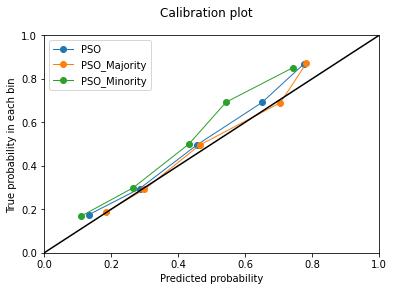

In [256]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_prob_lowuei, n_bins=5)
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Run1'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Run1'].values.reshape(-1,1), n_bins=5)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(prob_true, prob_pred, marker='o', linewidth=1, label='PSO')
plt.plot(prob_true_maj, prob_pred_maj, marker='o', linewidth=1, label='PSO_Majority')
plt.plot(prob_true_min, prob_pred_min, marker='o', linewidth=1, label='PSO_Minority')

# plt.plot(prob_true_dnn, prob_pred_dnn, marker='x', linewidth=1, label='Point Estimate')
# plt.plot(prob_true_dnn_maj, prob_pre_dnnd_maj, marker='x', linewidth=1, label='Dropout(0.2)')
# plt.plot(prob_true_dnn_min, prob_pred_dnn_min, marker='x', linewidth=1, label='Dropout(0.2)')


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

plt.legend()
plt.show()

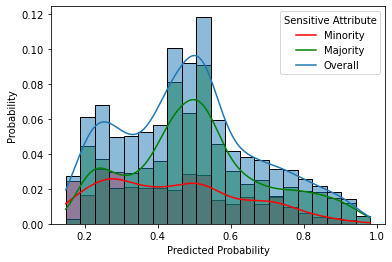

In [295]:
import seaborn as sns
c = {}
c['Predicted Probability'] = y_prob_lowuei.ravel()
c['sex'] = Xtest[:,-1]
c = pd.DataFrame(c)

sns.histplot(data=c,x='Predicted Probability',hue='sex',multiple='layer',stat='probability',kde=True,legend=False,palette=["green", "red"])
sns.histplot(data=c,x='Predicted Probability',stat='probability',kde=True)
plt.legend(title='Sensitive Attribute', loc='upper right', labels=['Minority', 'Majority','Overall'])

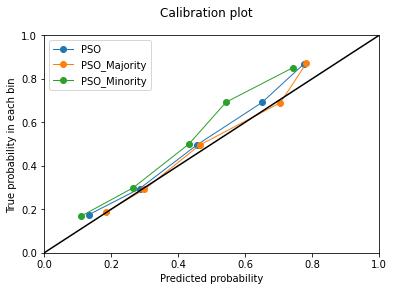

In [198]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_prob_lowuei, n_bins=5)
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Run1'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Run1'].values.reshape(-1,1), n_bins=5)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(prob_true, prob_pred, marker='o', linewidth=1, label='PSO')
plt.plot(prob_true_maj, prob_pred_maj, marker='o', linewidth=1, label='PSO_Majority')
plt.plot(prob_true_min, prob_pred_min, marker='o', linewidth=1, label='PSO_Minority')

# plt.plot(prob_true_dnn, prob_pred_dnn, marker='x', linewidth=1, label='Point Estimate')
# plt.plot(prob_true_dnn_maj, prob_pre_dnnd_maj, marker='x', linewidth=1, label='Dropout(0.2)')
# plt.plot(prob_true_dnn_min, prob_pred_dnn_min, marker='x', linewidth=1, label='Dropout(0.2)')


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

plt.legend()
plt.show()

# PSO

In [3]:
df = pd.read_csv("recidivism.csv")
df.pop('Unnamed: 0')
df.head()

y = df['Recid2Y'].values
df.pop('Recid2Y')
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle = True, random_state=40, stratify = y)
Xtrain_num = X_train[['age','juv_fel_count','juv_misd_count','priors_count']]
x_train_cat = X_train[['Gender','Felony','Caucasian']]
Xtest_num = X_test[['age','juv_fel_count','juv_misd_count','priors_count']]
x_test_cat = X_test[['Gender','Felony','Caucasian']]

stdscl = StandardScaler()
Xtrain_num = stdscl.fit_transform(Xtrain_num)
Xtest_num = stdscl.transform(Xtest_num)

Xtrain = np.hstack((Xtrain_num,x_train_cat))
Xtest = np.hstack((Xtest_num,x_test_cat))

In [97]:
def initialize_weight(n_coef):
    w = np.random.normal(0, 1, size=(1, n_coef))
    return w

def randomized_network(hidden_size = [5,10,12]):
    W_vel = [np.random.randn(j,i) for i,j in zip(hidden_size[:-1],hidden_size[1:])]
    B_vel = [np.random.randn(i,1) for i in hidden_size[1:]]
    return W_vel,B_vel

def initialize_network(hidden_size = [5,10,12]):
    W = [np.random.randn(j,i) for i,j in zip(hidden_size[:-1],hidden_size[1:])]
    B = [np.random.randn(i,1) for i in hidden_size[1:]]
    return W,B

def initialize_velocity(hidden_size = [5,10,12]):
    W_vel = [np.zeros((j,i)) for i,j in zip(hidden_size[:-1],hidden_size[1:])]
    B_vel = [np.zeros((i,1)) for i in hidden_size[1:]]
    return W_vel,B_vel

def rand_weight(dimension):
    weight_or_bias = np.random.choice(len(dimension))
    which_layer = np.random.choice(len(dimension[weight_or_bias]))
    which_node = np.random.choice(len(dimension[weight_or_bias][which_layer].ravel()))
    dimension[weight_or_bias][which_layer].ravel()[which_node] = np.random.normal(0, 1, 1)
    return np.asarray(dimension)

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# correct solution:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

def predict(w,b,x,threshold=0.5):
    return np.where((1/(1+np.exp(-(x@w.T+b))))>threshold,1,0).ravel()

def evaluate(y_true,y_pred,sa):
    ## convert the probability estimates to class labels (MC Dropout)
    
    ba = nll1(y_true,y_pred)
    us_s = UEI(sa, y_true, np.round(y_pred))
    return ba.numpy(),us_s

# Generate hypercubes of the search space exlored so far

def createGrid(population,nGrid,alpha,nObj):
    costs = [item.cost for item in repos]
    cmin = np.min(costs,axis=0)
    cmax = np.max(costs,axis=0)
    cmin = cmin- (alpha*(cmax-cmin))
    cmax = cmax+ (alpha*(cmax-cmin))

    grid = [gridDim() for p in range(nObj)]
    
    for i in range(nObj):
        dimValues = np.linspace(cmin[i],cmax[i],nGrid).tolist()
        grid[i].lowerBounds = [-float('inf')]  + dimValues
        grid[i].upperBounds = dimValues + [float('inf')]
        
    return grid

def Dominates(x,y):
    ## Return True if accuracy is higher and UEI is smaller 
    if (x[0] < y[0]) and (x[1] < y[1]):
        return True
    else:
        return False
    
def determineDomination(pop):
    for i in range(len(pop)):
        pop[i].isDominated = False
        
    for i in range(len(pop) - 1):
        for j in range(i+1,len(pop)):
            if Dominates(pop[i].cost,pop[j].cost):
                pop[j].isDominated = True
            if Dominates(pop[j].cost,pop[i].cost):
                pop[i].isDominated = True
#             if pop[i].cost == pop[j].cost and not Dominates(pop[i].cost,pop[j].cost):
# #                 print(pop[i].cost)
#                 pop[i].isDominated = False
#                 pop[j].isDominated = True
    
    return pop

def findIndex(particle,grid,nObj,nGrid):
    
    # find the location of the particle in the grid 
    particle.gridSubIndex = np.zeros((1,nObj))[0]
    for i in range(nObj):
        index_in_dim = len( [item for item in grid[i].upperBounds if particle.cost[i] > item] )
        particle.gridSubIndex[i] = index_in_dim
        
    
    particle.gridIndex = particle.gridSubIndex[0]
    for i in range(1,nObj):
        particle.gridIndex = particle.gridIndex
        particle.gridIndex = nGrid*particle.gridIndex
        particle.gridIndex = particle.gridIndex + particle.gridSubIndex[i]
        
    return particle

def rouletteWheelSelection(prob):
    return len([i for i in (np.cumsum(prob) < random.random()) if i == True])
    
def selectLeader(rep,beta):
    gridIndices = [item.gridIndex for item in rep]
    Ocells = np.unique(gridIndices)
    N = np.zeros(len(Ocells))
    
    for i in range(len(Ocells)):
        N[i] = gridIndices.count(Ocells[i])
    
    probability = [np.exp(-beta*item) for item in N]
    probability = np.array(probability)/sum(probability)
    
    sci = rouletteWheelSelection(probability)
    selectedCell = Ocells[sci]
    
    selectedCellMembers = [item for item in gridIndices if item == selectedCell]
    selectedMemberIndex = np.random.randint(0,len(selectedCellMembers))
    
    return rep[selectedMemberIndex]

def deleteOneMember(rep,gamma):
    gridIndices = [item.gridIndex for item in rep]
    Ocells = np.unique(gridIndices)
    N = np.zeros(len(Ocells))
    
    for i in range(len(Ocells)):
        N[i] = gridIndices.count(Ocells[i])
    
    probability = [np.exp(gamma*item) for item in N]
    probability = np.array(probability)/sum(probability)
    
    sci = rouletteWheelSelection(probability)
#     print(sci)
    selectedCell = Ocells[sci]
    
    selectedCellMembers = [item for item in gridIndices if item == selectedCell]
    selectedMemberIndex = np.random.randint(0,len(selectedCellMembers))
    rep = np.delete(rep,selectedMemberIndex)
    return rep.tolist()

def deleteOneMember(rep,gamma):
    gridIndices = [item.gridIndex for item in rep]
    Ocells = np.unique(gridIndices)
    N = np.zeros(len(Ocells))
    
    for i in range(len(Ocells)):
        N[i] = gridIndices.count(Ocells[i])
    
    probability = [np.exp(gamma*item) for item in N]
    probability = np.array(probability)/sum(probability)
    
    sci = rouletteWheelSelection(probability)
#     print(sci)
    selectedCell = Ocells[sci]
    
    selectedCellMembers = [item for item in gridIndices if item == selectedCell]
    selectedMemberIndex = np.random.randint(0,len(selectedCellMembers))
    rep = np.delete(rep,selectedMemberIndex)
    return rep.tolist()

def perturbOneMember(rep,gamma):
    gridIndices = [item.gridIndex for item in rep]
    Ocells = np.unique(gridIndices)
    N = np.zeros(len(Ocells))
    
    for i in range(len(Ocells)):
        N[i] = gridIndices.count(Ocells[i])
    
    probability = [np.exp(gamma*item) for item in N]
    probability = np.array(probability)/sum(probability)
    
    sci = rouletteWheelSelection(probability)
    selectedCell = Ocells[sci]
    
    selectedCellMembers = [item for item in gridIndices if item == selectedCell]
    selectedMemberIndex = np.random.randint(0,len(selectedCellMembers))
    rep[selectedMemberIndex].position = rep[selectedMemberIndex].position + np.asarray(randomized_network([Xtrain.shape[1],5,1])) * 0.1
    w_tmp = rep[selectedMemberIndex].position.ravel()[:2]
    b_tmp = rep[selectedMemberIndex].position.ravel()[-2]
    y_pred = feedforward(Xtrain.T,w_tmp,b_tmp).T
    best_ba,best_us = evaluate(y_train,y_pred.ravel(),Xtrain[:,-1])
    rep[selectedMemberIndex].cost = [best_ba,best_us]
    rep = determineDomination(rep)
    repos = [item for item in rep if item.isDominated == False]
    return repos

class Particle:
    position = []
    cost = []
    velocity = []
    best_position = []
    isDominated = []
    gridIndex = []
    gridSubIndex = []
    
class gridDim:
    lowerBounds = []
    upperBounds = []

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

3


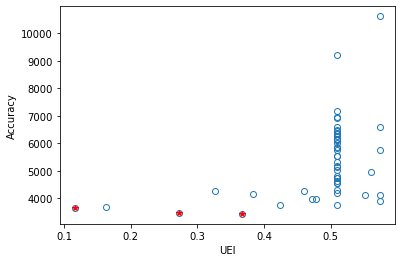

  0%|▍                                                                                | 5/1000 [00:01<04:32,  3.65it/s]

4


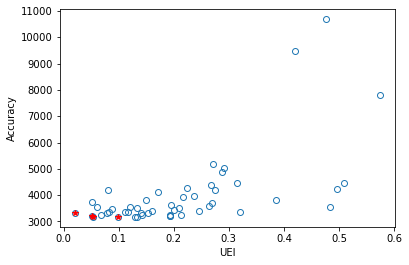

  1%|▊                                                                               | 10/1000 [00:02<04:25,  3.73it/s]

11


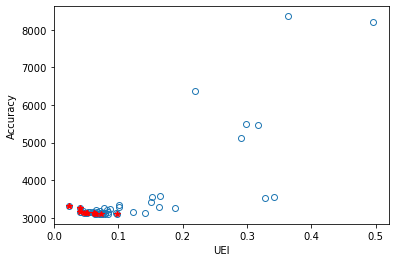

  2%|█▏                                                                              | 15/1000 [00:04<04:59,  3.29it/s]

11


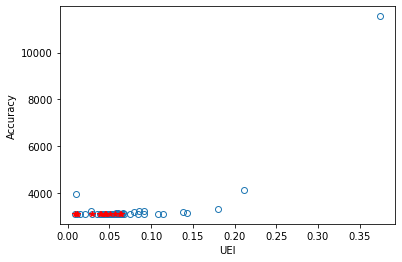

  2%|█▌                                                                              | 20/1000 [00:05<04:32,  3.59it/s]

17


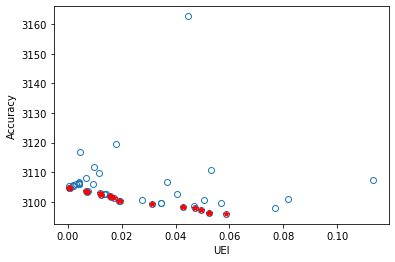

  2%|██                                                                              | 25/1000 [00:07<04:57,  3.28it/s]

10


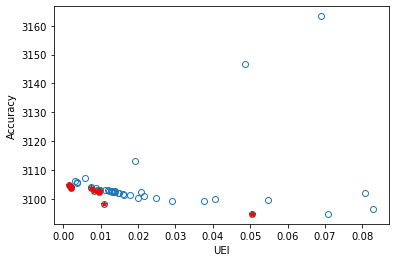

  3%|██▍                                                                             | 30/1000 [00:09<04:36,  3.51it/s]

18


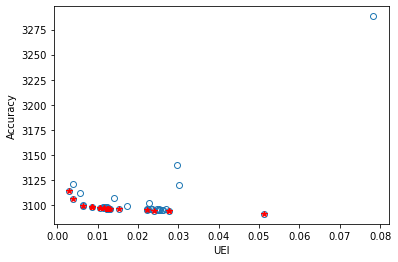

  4%|██▊                                                                             | 35/1000 [00:10<04:21,  3.69it/s]

26


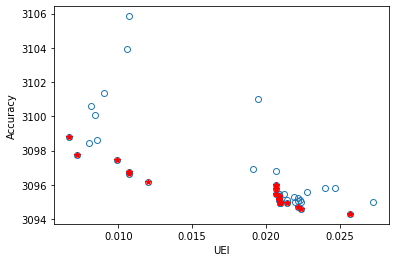

  4%|███                                                                             | 39/1000 [00:11<04:33,  3.51it/s]

Force Reached!


  4%|███▏                                                                            | 40/1000 [00:11<04:56,  3.23it/s]

Force Reached!
Force Reached!
42


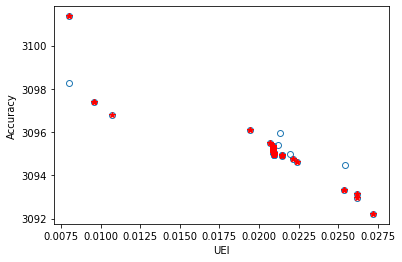

  4%|███▎                                                                            | 42/1000 [00:12<05:42,  2.80it/s]

Force Reached!


  4%|███▍                                                                            | 43/1000 [00:13<05:51,  2.72it/s]

Force Reached!


  4%|███▌                                                                            | 44/1000 [00:13<05:54,  2.69it/s]

Force Reached!


  4%|███▌                                                                            | 45/1000 [00:13<05:47,  2.75it/s]

Force Reached!
Force Reached!
47


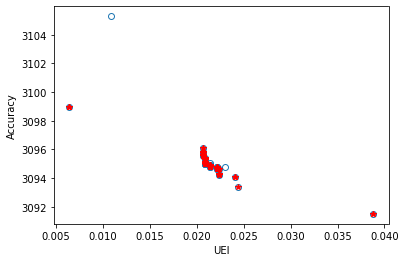

  5%|███▊                                                                            | 47/1000 [00:14<05:56,  2.67it/s]

Force Reached!


  5%|███▉                                                                            | 49/1000 [00:15<05:33,  2.85it/s]

Force Reached!


  5%|████                                                                            | 50/1000 [00:15<05:28,  2.89it/s]

Force Reached!
Force Reached!
39


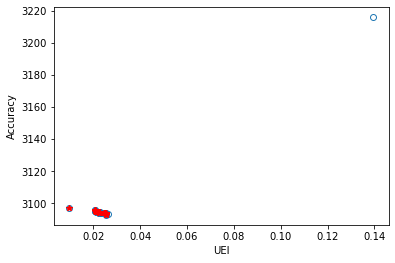

  5%|████▏                                                                           | 52/1000 [00:16<05:45,  2.74it/s]

Force Reached!


  5%|████▏                                                                           | 53/1000 [00:16<05:54,  2.67it/s]

Force Reached!


  5%|████▎                                                                           | 54/1000 [00:17<05:37,  2.81it/s]

Force Reached!


  6%|████▍                                                                           | 55/1000 [00:17<05:30,  2.86it/s]

Force Reached!
Force Reached!
43


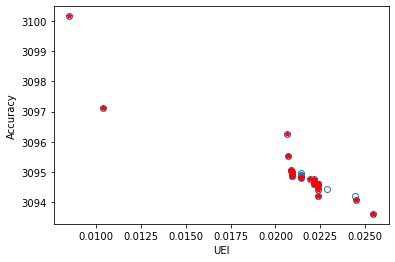

  6%|████▌                                                                           | 57/1000 [00:18<06:01,  2.61it/s]

Force Reached!


  6%|████▋                                                                           | 58/1000 [00:18<06:04,  2.58it/s]

Force Reached!


  6%|████▋                                                                           | 59/1000 [00:19<06:17,  2.49it/s]

Force Reached!


  6%|████▊                                                                           | 60/1000 [00:19<06:11,  2.53it/s]

Force Reached!
Force Reached!
46


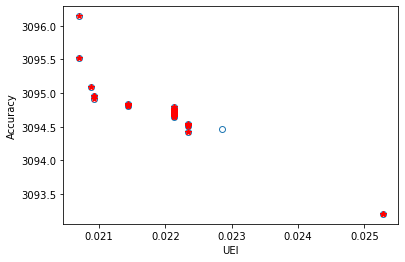

  6%|████▉                                                                           | 62/1000 [00:20<06:36,  2.37it/s]

Force Reached!


  6%|█████                                                                           | 63/1000 [00:20<06:32,  2.38it/s]

Force Reached!


  6%|█████                                                                           | 64/1000 [00:21<06:32,  2.38it/s]

Force Reached!


  6%|█████▏                                                                          | 65/1000 [00:21<06:37,  2.35it/s]

Force Reached!
Force Reached!
42


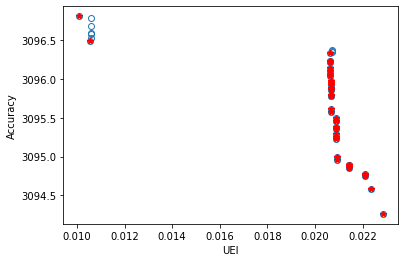

  7%|█████▎                                                                          | 67/1000 [00:22<06:31,  2.38it/s]

Force Reached!


  7%|█████▍                                                                          | 68/1000 [00:23<06:34,  2.36it/s]

Force Reached!


  7%|█████▌                                                                          | 69/1000 [00:23<06:24,  2.42it/s]

Force Reached!


  7%|█████▌                                                                          | 70/1000 [00:23<06:19,  2.45it/s]

Force Reached!
Force Reached!
47


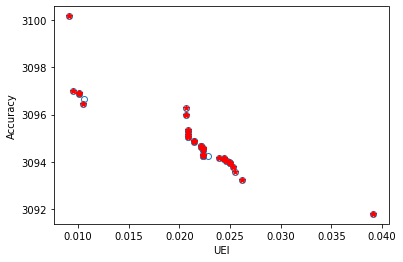

  7%|█████▊                                                                          | 72/1000 [00:24<06:43,  2.30it/s]

Force Reached!


  7%|█████▊                                                                          | 73/1000 [00:25<06:37,  2.33it/s]

Force Reached!


  7%|█████▉                                                                          | 74/1000 [00:25<06:32,  2.36it/s]

Force Reached!


  8%|██████                                                                          | 75/1000 [00:26<06:43,  2.29it/s]

Force Reached!
Force Reached!
49


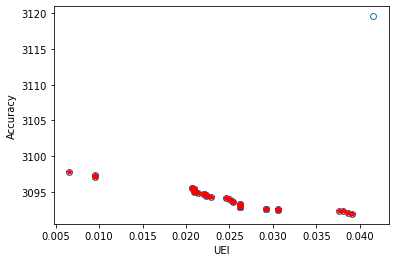

  8%|██████▏                                                                         | 77/1000 [00:26<06:56,  2.22it/s]

Force Reached!


  8%|██████▏                                                                         | 78/1000 [00:27<06:50,  2.25it/s]

Force Reached!


  8%|██████▎                                                                         | 79/1000 [00:27<06:46,  2.26it/s]

Force Reached!


  8%|██████▍                                                                         | 80/1000 [00:28<06:32,  2.34it/s]

Force Reached!
Force Reached!
47


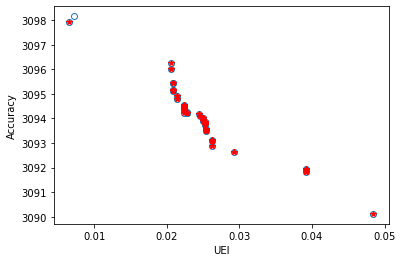

  8%|██████▌                                                                         | 82/1000 [00:29<06:37,  2.31it/s]

Force Reached!


  8%|██████▋                                                                         | 83/1000 [00:29<06:38,  2.30it/s]

Force Reached!


  8%|██████▋                                                                         | 84/1000 [00:29<06:33,  2.33it/s]

Force Reached!


  8%|██████▊                                                                         | 85/1000 [00:30<06:44,  2.26it/s]

Force Reached!
Force Reached!
48


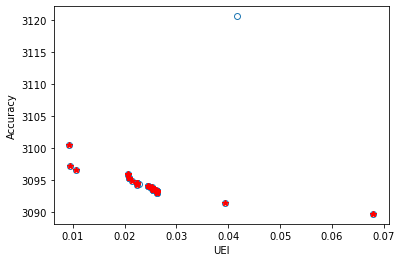

  9%|██████▉                                                                         | 87/1000 [00:31<06:52,  2.22it/s]

Force Reached!


  9%|███████                                                                         | 88/1000 [00:31<06:51,  2.22it/s]

Force Reached!


  9%|███████                                                                         | 89/1000 [00:32<06:35,  2.30it/s]

Force Reached!


  9%|███████▏                                                                        | 90/1000 [00:32<06:27,  2.35it/s]

Force Reached!
Force Reached!
49


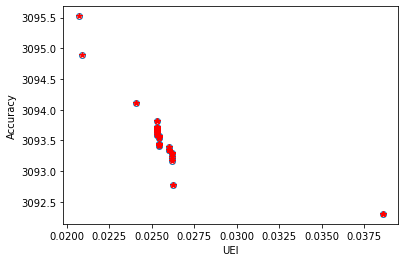

  9%|███████▎                                                                        | 92/1000 [00:33<06:45,  2.24it/s]

Force Reached!


  9%|███████▍                                                                        | 93/1000 [00:34<06:38,  2.28it/s]

Force Reached!


  9%|███████▌                                                                        | 94/1000 [00:34<06:37,  2.28it/s]

Force Reached!


 10%|███████▌                                                                        | 95/1000 [00:34<06:31,  2.31it/s]

Force Reached!
Force Reached!
50


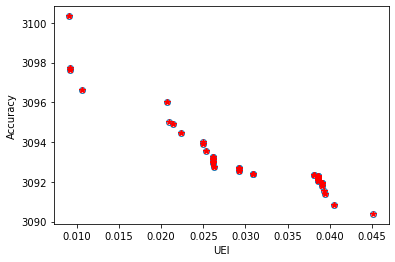

 10%|███████▊                                                                        | 97/1000 [00:35<06:20,  2.37it/s]

Force Reached!


 10%|███████▊                                                                        | 98/1000 [00:36<06:19,  2.37it/s]

Force Reached!


 10%|███████▉                                                                        | 99/1000 [00:36<06:08,  2.45it/s]

Force Reached!


 10%|███████▉                                                                       | 100/1000 [00:36<06:07,  2.45it/s]

Force Reached!
Force Reached!
49


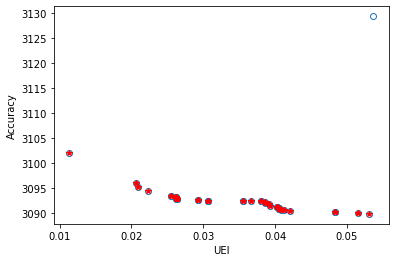

 10%|████████                                                                       | 102/1000 [00:37<06:09,  2.43it/s]

Force Reached!


 10%|████████▏                                                                      | 103/1000 [00:38<06:11,  2.42it/s]

Force Reached!


 10%|████████▏                                                                      | 104/1000 [00:38<06:02,  2.47it/s]

Force Reached!


 10%|████████▎                                                                      | 105/1000 [00:39<06:04,  2.46it/s]

Force Reached!
Force Reached!
44


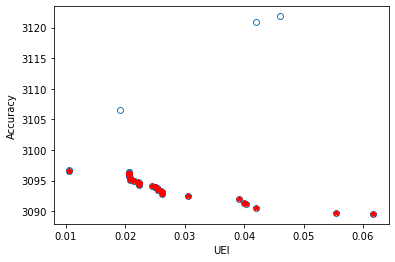

 11%|████████▍                                                                      | 107/1000 [00:39<05:58,  2.49it/s]

Force Reached!


 11%|████████▌                                                                      | 108/1000 [00:40<05:58,  2.49it/s]

Force Reached!


 11%|████████▌                                                                      | 109/1000 [00:40<05:50,  2.54it/s]

Force Reached!


 11%|████████▋                                                                      | 110/1000 [00:40<05:37,  2.64it/s]

Force Reached!
Force Reached!
47


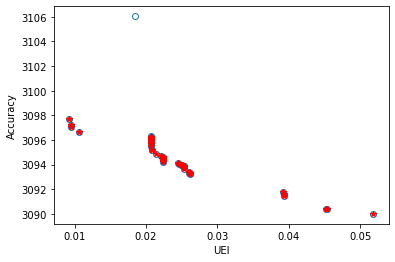

 11%|████████▊                                                                      | 112/1000 [00:41<06:02,  2.45it/s]

Force Reached!


 11%|████████▉                                                                      | 113/1000 [00:42<05:59,  2.47it/s]

Force Reached!


 11%|█████████                                                                      | 114/1000 [00:42<05:57,  2.48it/s]

Force Reached!


 12%|█████████                                                                      | 115/1000 [00:42<05:19,  2.77it/s]

Force Reached!
48


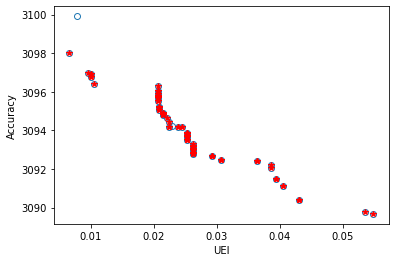

 12%|█████████▏                                                                     | 117/1000 [00:43<05:39,  2.60it/s]

Force Reached!


 12%|█████████▎                                                                     | 118/1000 [00:44<05:44,  2.56it/s]

Force Reached!


 12%|█████████▍                                                                     | 119/1000 [00:44<05:43,  2.56it/s]

Force Reached!


 12%|█████████▍                                                                     | 120/1000 [00:44<05:25,  2.70it/s]

Force Reached!
Force Reached!
36


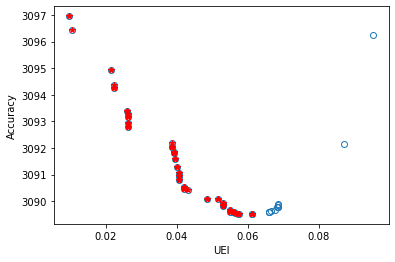

 12%|█████████▋                                                                     | 122/1000 [00:45<05:20,  2.74it/s]

Force Reached!


 12%|█████████▋                                                                     | 123/1000 [00:45<05:20,  2.73it/s]

Force Reached!


 12%|█████████▊                                                                     | 124/1000 [00:46<05:15,  2.77it/s]

Force Reached!


 12%|█████████▉                                                                     | 125/1000 [00:46<05:19,  2.74it/s]

Force Reached!
Force Reached!
48


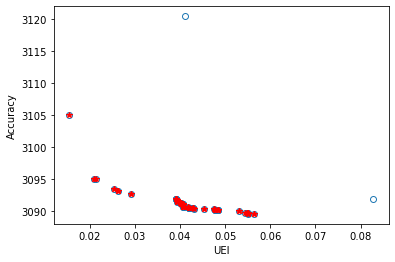

 13%|██████████                                                                     | 127/1000 [00:47<05:51,  2.49it/s]

Force Reached!


 13%|██████████                                                                     | 128/1000 [00:47<05:43,  2.54it/s]

Force Reached!


 13%|██████████▏                                                                    | 129/1000 [00:48<05:28,  2.65it/s]

Force Reached!


 13%|██████████▎                                                                    | 130/1000 [00:48<05:39,  2.56it/s]

Force Reached!
Force Reached!
47


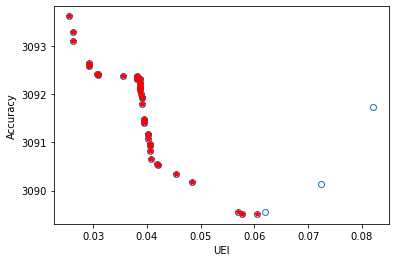

 13%|██████████▍                                                                    | 132/1000 [00:49<06:00,  2.41it/s]

Force Reached!


 13%|██████████▌                                                                    | 133/1000 [00:50<06:00,  2.40it/s]

Force Reached!


 13%|██████████▌                                                                    | 134/1000 [00:50<05:52,  2.46it/s]

Force Reached!


 14%|██████████▋                                                                    | 135/1000 [00:50<05:37,  2.56it/s]

Force Reached!
Force Reached!
46


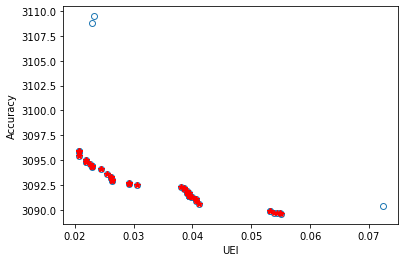

 14%|██████████▊                                                                    | 137/1000 [00:51<05:39,  2.54it/s]

Force Reached!


 14%|██████████▉                                                                    | 138/1000 [00:51<05:30,  2.61it/s]

Force Reached!


 14%|██████████▉                                                                    | 139/1000 [00:52<05:26,  2.64it/s]

Force Reached!


 14%|███████████                                                                    | 140/1000 [00:52<05:33,  2.58it/s]

Force Reached!
Force Reached!
46


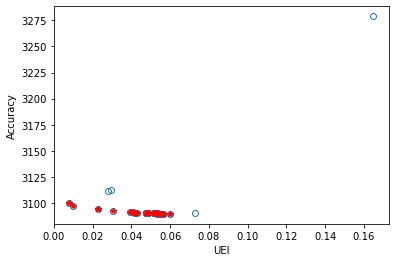

 14%|███████████▏                                                                   | 142/1000 [00:53<05:46,  2.47it/s]

Force Reached!


 14%|███████████▎                                                                   | 143/1000 [00:53<05:42,  2.50it/s]

Force Reached!


 14%|███████████▍                                                                   | 144/1000 [00:54<05:42,  2.50it/s]

Force Reached!


 14%|███████████▍                                                                   | 145/1000 [00:54<06:04,  2.35it/s]

Force Reached!
Force Reached!
45


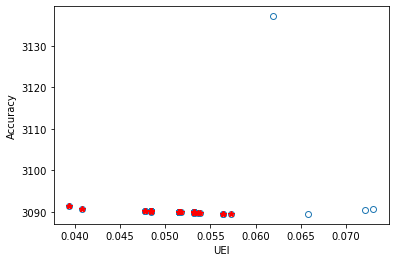

 15%|███████████▌                                                                   | 147/1000 [00:56<06:54,  2.06it/s]

Force Reached!


 15%|███████████▋                                                                   | 148/1000 [00:56<06:46,  2.10it/s]

Force Reached!


 15%|███████████▊                                                                   | 149/1000 [00:56<06:33,  2.16it/s]

Force Reached!


 15%|███████████▊                                                                   | 150/1000 [00:57<05:59,  2.36it/s]

Force Reached!
Force Reached!
48


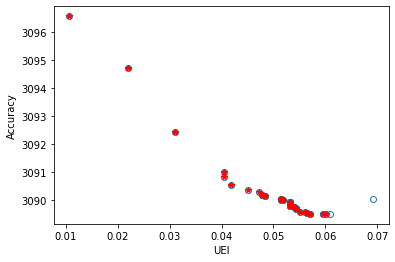

 15%|████████████                                                                   | 152/1000 [00:58<06:28,  2.18it/s]

Force Reached!


 15%|████████████                                                                   | 153/1000 [00:58<06:14,  2.26it/s]

Force Reached!


 15%|████████████▏                                                                  | 154/1000 [00:59<06:17,  2.24it/s]

Force Reached!


 16%|████████████▏                                                                  | 155/1000 [00:59<06:01,  2.34it/s]

Force Reached!
Force Reached!
49


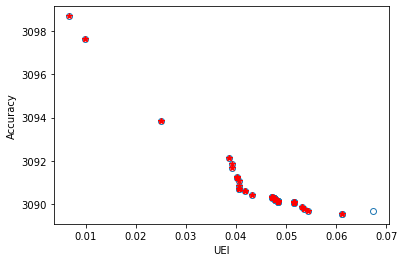

 16%|████████████▍                                                                  | 157/1000 [01:00<06:44,  2.09it/s]

Force Reached!


 16%|████████████▍                                                                  | 158/1000 [01:01<06:32,  2.14it/s]

Force Reached!


 16%|████████████▌                                                                  | 159/1000 [01:01<05:46,  2.43it/s]

Force Reached!


 16%|████████████▋                                                                  | 160/1000 [01:01<05:29,  2.55it/s]

Force Reached!
Force Reached!
41


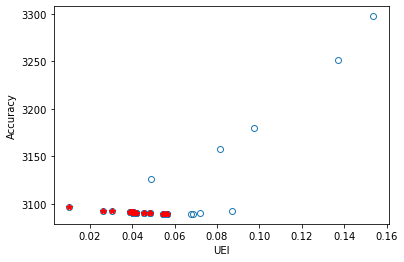

 16%|████████████▊                                                                  | 162/1000 [01:02<05:37,  2.48it/s]

Force Reached!


 16%|████████████▉                                                                  | 164/1000 [01:03<05:10,  2.69it/s]

Force Reached!


 16%|█████████████                                                                  | 165/1000 [01:03<05:33,  2.51it/s]

Force Reached!
Force Reached!
38


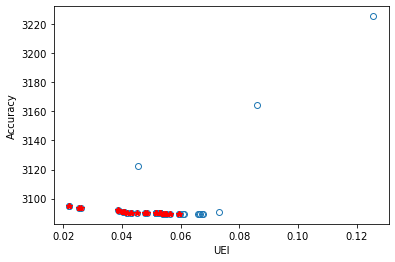

 17%|█████████████▏                                                                 | 167/1000 [01:04<05:25,  2.56it/s]

Force Reached!


 17%|█████████████▎                                                                 | 168/1000 [01:04<05:37,  2.47it/s]

Force Reached!


 17%|█████████████▎                                                                 | 169/1000 [01:05<05:39,  2.45it/s]

Force Reached!


 17%|█████████████▍                                                                 | 170/1000 [01:05<05:52,  2.35it/s]

Force Reached!
Force Reached!
46


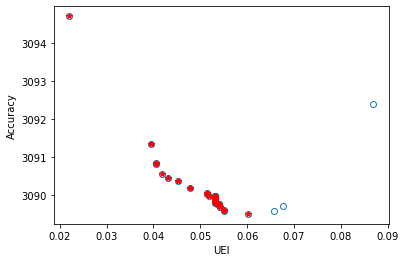

 17%|█████████████▌                                                                 | 172/1000 [01:06<06:05,  2.27it/s]

Force Reached!


 17%|█████████████▋                                                                 | 173/1000 [01:07<06:12,  2.22it/s]

Force Reached!


 17%|█████████████▋                                                                 | 174/1000 [01:07<06:12,  2.21it/s]

Force Reached!


 18%|█████████████▊                                                                 | 175/1000 [01:07<06:03,  2.27it/s]

Force Reached!
Force Reached!
47


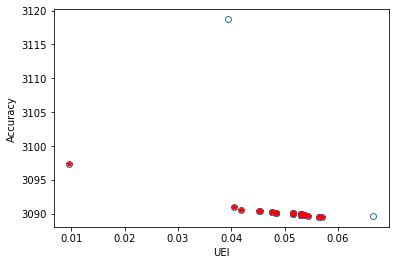

 18%|█████████████▉                                                                 | 177/1000 [01:08<06:19,  2.17it/s]

Force Reached!


 18%|██████████████                                                                 | 178/1000 [01:09<06:32,  2.09it/s]

Force Reached!


 18%|██████████████▏                                                                | 179/1000 [01:09<06:38,  2.06it/s]

Force Reached!
Force Reached!


 18%|██████████████▏                                                                | 180/1000 [01:10<06:49,  2.00it/s]

Force Reached!
49


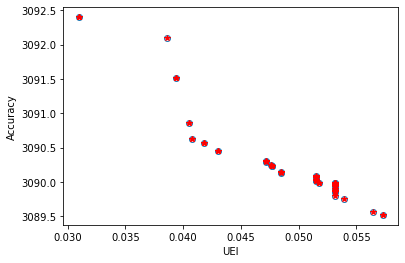

 18%|██████████████▍                                                                | 182/1000 [01:11<06:52,  1.98it/s]

Force Reached!


 18%|██████████████▍                                                                | 183/1000 [01:11<06:36,  2.06it/s]

Force Reached!
Force Reached!


 18%|██████████████▌                                                                | 184/1000 [01:12<07:04,  1.92it/s]

Force Reached!


 18%|██████████████▌                                                                | 185/1000 [01:13<06:56,  1.96it/s]

Force Reached!
42


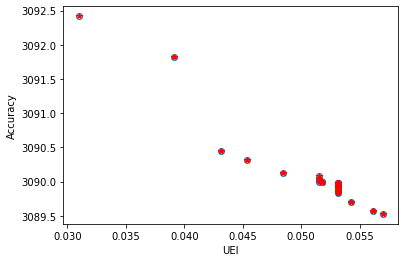

 19%|██████████████▊                                                                | 187/1000 [01:14<07:04,  1.92it/s]

Force Reached!


 19%|██████████████▊                                                                | 188/1000 [01:14<06:48,  1.99it/s]

Force Reached!


 19%|██████████████▉                                                                | 189/1000 [01:15<06:28,  2.09it/s]

Force Reached!


 19%|███████████████                                                                | 190/1000 [01:15<06:21,  2.12it/s]

Force Reached!
Force Reached!
48


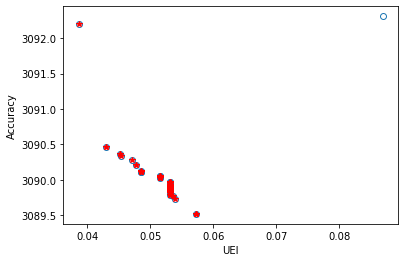

 19%|███████████████▏                                                               | 192/1000 [01:16<06:29,  2.07it/s]

Force Reached!


 19%|███████████████▏                                                               | 193/1000 [01:16<06:15,  2.15it/s]

Force Reached!


 19%|███████████████▎                                                               | 194/1000 [01:17<06:14,  2.15it/s]

Force Reached!


 20%|███████████████▍                                                               | 195/1000 [01:17<06:04,  2.21it/s]

Force Reached!
Force Reached!
50


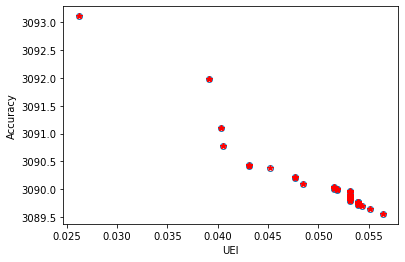

 20%|███████████████▌                                                               | 197/1000 [01:18<06:21,  2.10it/s]

Force Reached!


 20%|███████████████▋                                                               | 198/1000 [01:19<06:11,  2.16it/s]

Force Reached!


 20%|███████████████▋                                                               | 199/1000 [01:19<06:04,  2.20it/s]

Force Reached!


 20%|███████████████▊                                                               | 200/1000 [01:20<05:52,  2.27it/s]

Force Reached!
Force Reached!
48


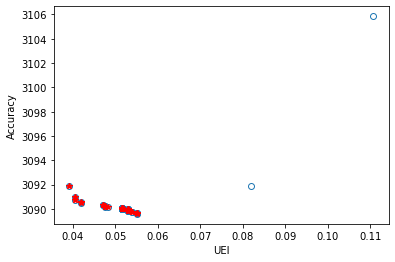

 20%|███████████████▉                                                               | 202/1000 [01:21<06:01,  2.21it/s]

Force Reached!


 20%|████████████████                                                               | 203/1000 [01:21<05:59,  2.22it/s]

Force Reached!


 20%|████████████████                                                               | 204/1000 [01:22<06:07,  2.16it/s]

Force Reached!


 20%|████████████████▏                                                              | 205/1000 [01:22<06:09,  2.15it/s]

Force Reached!
Force Reached!
48


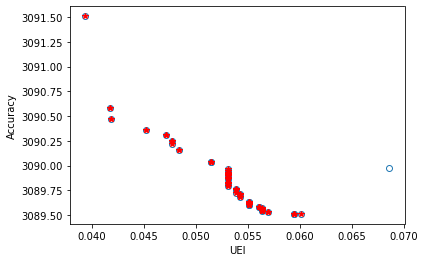

 21%|████████████████▎                                                              | 207/1000 [01:23<06:17,  2.10it/s]

Force Reached!


 21%|████████████████▍                                                              | 208/1000 [01:23<06:06,  2.16it/s]

Force Reached!


 21%|████████████████▌                                                              | 209/1000 [01:24<05:43,  2.30it/s]

Force Reached!


 21%|████████████████▌                                                              | 210/1000 [01:24<05:33,  2.37it/s]

Force Reached!
Force Reached!
41


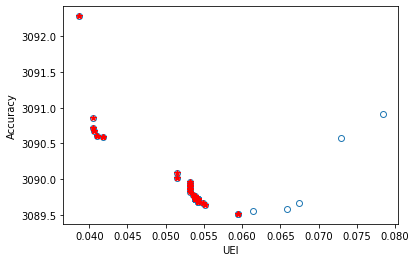

 21%|████████████████▋                                                              | 212/1000 [01:25<06:09,  2.13it/s]

Force Reached!


 21%|████████████████▊                                                              | 213/1000 [01:26<05:56,  2.21it/s]

Force Reached!


 21%|████████████████▉                                                              | 214/1000 [01:26<05:55,  2.21it/s]

Force Reached!


 22%|████████████████▉                                                              | 215/1000 [01:27<06:03,  2.16it/s]

Force Reached!
Force Reached!
46


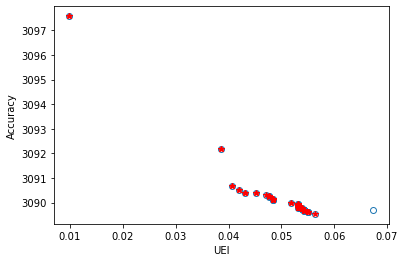

 22%|█████████████████▏                                                             | 217/1000 [01:28<06:09,  2.12it/s]

Force Reached!


 22%|█████████████████▏                                                             | 218/1000 [01:28<05:52,  2.22it/s]

Force Reached!


 22%|█████████████████▎                                                             | 219/1000 [01:28<05:44,  2.27it/s]

Force Reached!


 22%|█████████████████▍                                                             | 220/1000 [01:29<05:42,  2.28it/s]

Force Reached!
Force Reached!
49


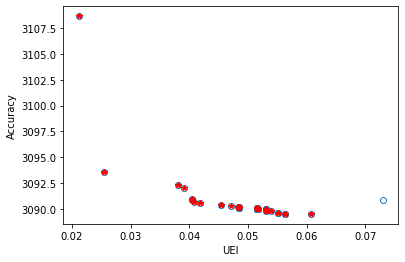

 22%|█████████████████▌                                                             | 222/1000 [01:30<06:13,  2.08it/s]

Force Reached!


 22%|█████████████████▌                                                             | 223/1000 [01:30<06:10,  2.10it/s]

Force Reached!


 22%|█████████████████▋                                                             | 224/1000 [01:31<06:12,  2.08it/s]

Force Reached!


 22%|█████████████████▊                                                             | 225/1000 [01:31<05:56,  2.17it/s]

Force Reached!
Force Reached!
47


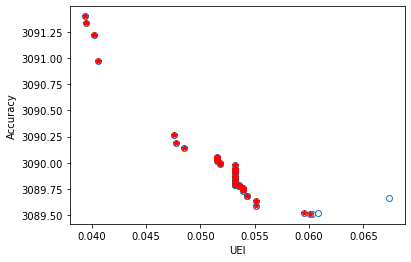

 23%|█████████████████▉                                                             | 227/1000 [01:32<06:01,  2.14it/s]

Force Reached!


 23%|██████████████████                                                             | 228/1000 [01:33<06:00,  2.14it/s]

Force Reached!


 23%|██████████████████                                                             | 229/1000 [01:33<05:49,  2.20it/s]

Force Reached!


 23%|██████████████████▏                                                            | 230/1000 [01:34<05:44,  2.23it/s]

Force Reached!
Force Reached!
48


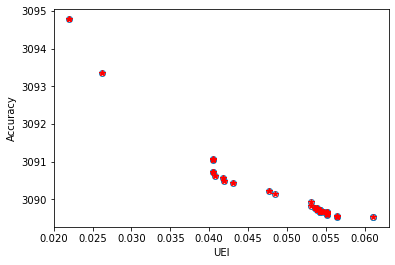

 23%|██████████████████▎                                                            | 232/1000 [01:35<05:51,  2.18it/s]

Force Reached!


 23%|██████████████████▍                                                            | 233/1000 [01:35<05:41,  2.25it/s]

Force Reached!


 23%|██████████████████▍                                                            | 234/1000 [01:35<05:25,  2.35it/s]

Force Reached!


 24%|██████████████████▌                                                            | 235/1000 [01:36<05:24,  2.35it/s]

Force Reached!
Force Reached!
37


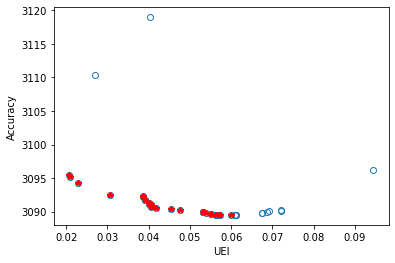

 24%|██████████████████▋                                                            | 237/1000 [01:37<05:37,  2.26it/s]

Force Reached!


 24%|██████████████████▊                                                            | 238/1000 [01:37<05:31,  2.30it/s]

Force Reached!


 24%|██████████████████▉                                                            | 239/1000 [01:38<05:29,  2.31it/s]

Force Reached!


 24%|██████████████████▉                                                            | 240/1000 [01:38<05:33,  2.28it/s]

Force Reached!
Force Reached!
43


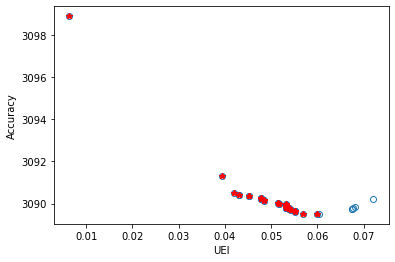

 24%|███████████████████                                                            | 242/1000 [01:39<05:53,  2.14it/s]

Force Reached!


 24%|███████████████████▏                                                           | 243/1000 [01:39<05:40,  2.23it/s]

Force Reached!


 24%|███████████████████▎                                                           | 244/1000 [01:40<05:43,  2.20it/s]

Force Reached!


 24%|███████████████████▎                                                           | 245/1000 [01:40<05:56,  2.12it/s]

Force Reached!
Force Reached!
44


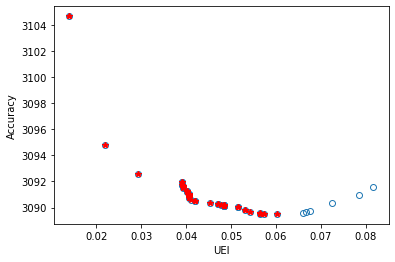

 25%|███████████████████▌                                                           | 247/1000 [01:41<05:54,  2.12it/s]

Force Reached!
Force Reached!


 25%|███████████████████▌                                                           | 248/1000 [01:42<06:00,  2.09it/s]

Force Reached!


 25%|███████████████████▊                                                           | 250/1000 [01:44<08:18,  1.50it/s]

Force Reached!
Force Reached!
48


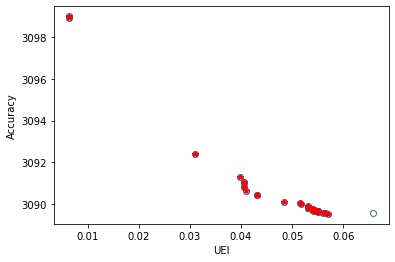

 25%|███████████████████▉                                                           | 252/1000 [01:45<07:29,  1.66it/s]

Force Reached!


 25%|███████████████████▉                                                           | 253/1000 [01:45<06:47,  1.83it/s]

Force Reached!


 25%|████████████████████                                                           | 254/1000 [01:46<06:22,  1.95it/s]

Force Reached!


 26%|████████████████████▏                                                          | 255/1000 [01:46<06:06,  2.03it/s]

Force Reached!
Force Reached!
47


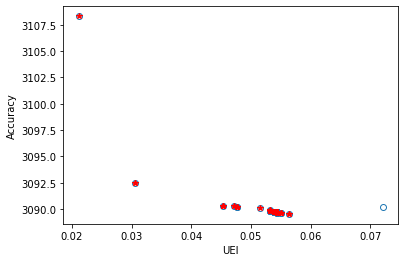

 26%|████████████████████▎                                                          | 257/1000 [01:47<06:08,  2.02it/s]

Force Reached!


 26%|████████████████████▍                                                          | 258/1000 [01:47<05:57,  2.07it/s]

Force Reached!


 26%|████████████████████▍                                                          | 259/1000 [01:48<05:57,  2.07it/s]

Force Reached!


 26%|████████████████████▌                                                          | 260/1000 [01:48<05:50,  2.11it/s]

Force Reached!
Force Reached!
39


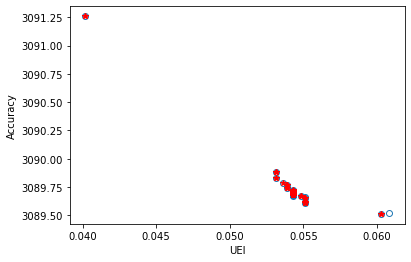

 26%|████████████████████▋                                                          | 262/1000 [01:49<05:53,  2.09it/s]

Force Reached!


 26%|████████████████████▊                                                          | 263/1000 [01:50<05:57,  2.06it/s]

Force Reached!


 26%|████████████████████▊                                                          | 264/1000 [01:50<05:52,  2.09it/s]

Force Reached!


 26%|████████████████████▉                                                          | 265/1000 [01:51<05:49,  2.10it/s]

Force Reached!
Force Reached!
42


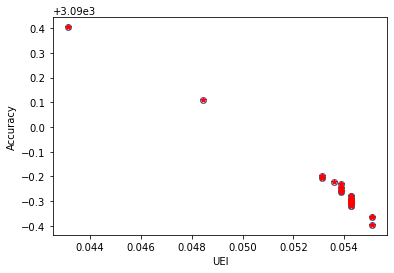

 27%|█████████████████████                                                          | 267/1000 [01:52<05:50,  2.09it/s]

Force Reached!


 27%|█████████████████████▏                                                         | 268/1000 [01:52<05:45,  2.12it/s]

Force Reached!


 27%|█████████████████████▎                                                         | 269/1000 [01:53<05:40,  2.15it/s]

Force Reached!


 27%|█████████████████████▎                                                         | 270/1000 [01:53<05:49,  2.09it/s]

Force Reached!
Force Reached!
47


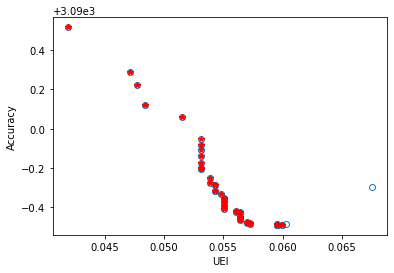

 27%|█████████████████████▍                                                         | 271/1000 [01:54<06:28,  1.88it/s]

Force Reached!


 27%|█████████████████████▌                                                         | 273/1000 [01:55<06:44,  1.80it/s]

Force Reached!


 27%|█████████████████████▋                                                         | 274/1000 [01:55<06:18,  1.92it/s]

Force Reached!


 28%|█████████████████████▋                                                         | 275/1000 [01:56<06:07,  1.97it/s]

Force Reached!
Force Reached!
46


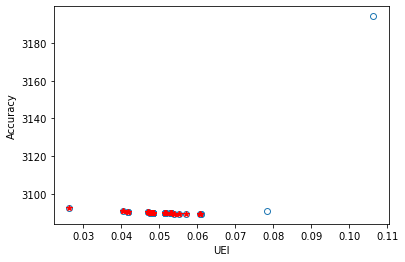

 28%|█████████████████████▉                                                         | 277/1000 [01:57<05:57,  2.02it/s]

Force Reached!


 28%|█████████████████████▉                                                         | 278/1000 [01:57<05:46,  2.08it/s]

Force Reached!


 28%|██████████████████████                                                         | 279/1000 [01:58<05:38,  2.13it/s]

Force Reached!


 28%|██████████████████████                                                         | 280/1000 [01:58<05:46,  2.08it/s]

Force Reached!
Force Reached!
50


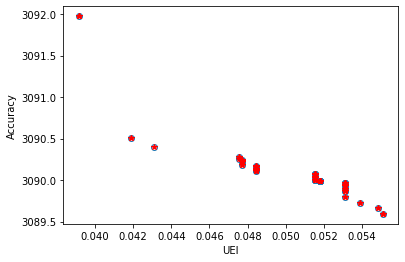

 28%|██████████████████████▎                                                        | 282/1000 [01:59<05:53,  2.03it/s]

Force Reached!


 28%|██████████████████████▎                                                        | 283/1000 [02:00<05:49,  2.05it/s]

Force Reached!


 28%|██████████████████████▍                                                        | 284/1000 [02:00<05:51,  2.04it/s]

Force Reached!


 28%|██████████████████████▌                                                        | 285/1000 [02:01<05:54,  2.02it/s]

Force Reached!
Force Reached!
50


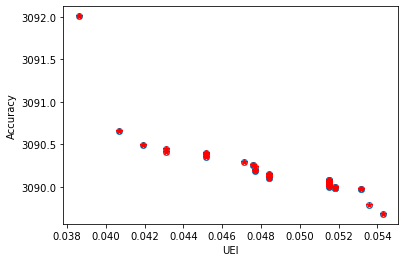

 29%|██████████████████████▋                                                        | 287/1000 [02:02<06:05,  1.95it/s]

Force Reached!


 29%|██████████████████████▊                                                        | 288/1000 [02:02<06:02,  1.96it/s]

Force Reached!


 29%|██████████████████████▊                                                        | 289/1000 [02:03<05:51,  2.02it/s]

Force Reached!


 29%|██████████████████████▉                                                        | 290/1000 [02:03<05:47,  2.04it/s]

Force Reached!
Force Reached!
36


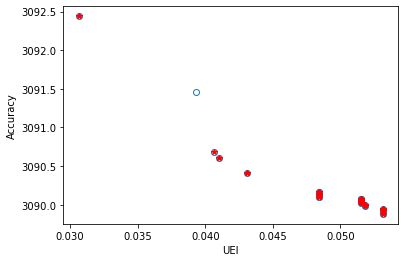

 29%|███████████████████████                                                        | 292/1000 [02:04<05:44,  2.06it/s]

Force Reached!


 29%|███████████████████████▏                                                       | 293/1000 [02:05<05:32,  2.12it/s]

Force Reached!


 29%|███████████████████████▏                                                       | 294/1000 [02:05<05:26,  2.16it/s]

Force Reached!


 30%|███████████████████████▎                                                       | 295/1000 [02:06<05:34,  2.11it/s]

Force Reached!
Force Reached!
35


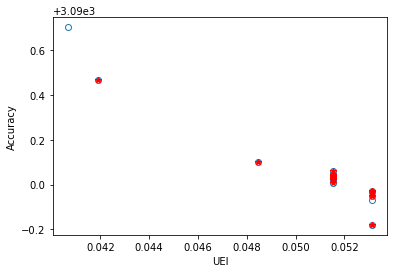

 30%|███████████████████████▍                                                       | 297/1000 [02:07<05:59,  1.95it/s]

Force Reached!


 30%|███████████████████████▌                                                       | 298/1000 [02:07<05:47,  2.02it/s]

Force Reached!


 30%|███████████████████████▌                                                       | 299/1000 [02:08<05:39,  2.07it/s]

Force Reached!


 30%|███████████████████████▋                                                       | 300/1000 [02:08<05:44,  2.03it/s]

Force Reached!
Force Reached!
44


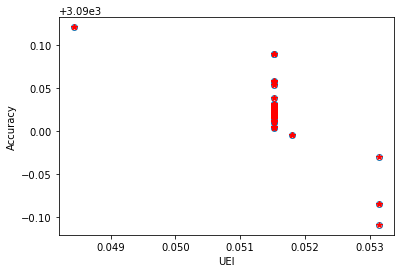

 30%|███████████████████████▊                                                       | 302/1000 [02:09<05:39,  2.06it/s]

Force Reached!


 30%|███████████████████████▉                                                       | 303/1000 [02:10<05:39,  2.05it/s]

Force Reached!


 30%|████████████████████████                                                       | 304/1000 [02:10<05:32,  2.09it/s]

Force Reached!


 30%|████████████████████████                                                       | 305/1000 [02:11<05:28,  2.11it/s]

Force Reached!
Force Reached!
50


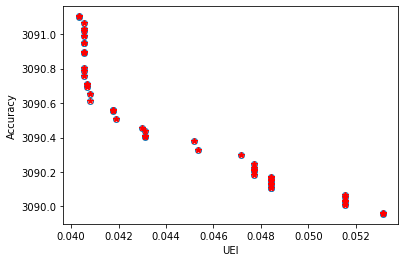

 31%|████████████████████████▎                                                      | 307/1000 [02:12<05:40,  2.04it/s]

Force Reached!


 31%|████████████████████████▎                                                      | 308/1000 [02:12<05:33,  2.07it/s]

Force Reached!


 31%|████████████████████████▍                                                      | 309/1000 [02:13<05:09,  2.23it/s]

Force Reached!


 31%|████████████████████████▍                                                      | 310/1000 [02:13<05:05,  2.26it/s]

Force Reached!
Force Reached!
48


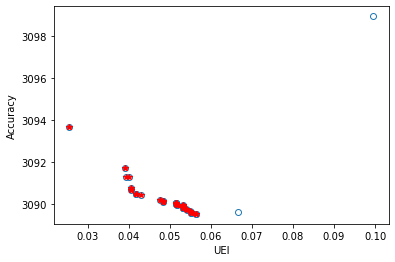

 31%|████████████████████████▋                                                      | 312/1000 [02:14<05:13,  2.20it/s]

Force Reached!


 31%|████████████████████████▋                                                      | 313/1000 [02:14<05:05,  2.25it/s]

Force Reached!
Force Reached!


 31%|████████████████████████▊                                                      | 314/1000 [02:15<05:18,  2.16it/s]

Force Reached!


 32%|████████████████████████▉                                                      | 315/1000 [02:15<05:39,  2.02it/s]

Force Reached!
47


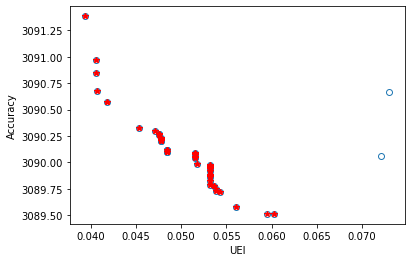

 32%|████████████████████████▉                                                      | 316/1000 [02:16<06:07,  1.86it/s]

Force Reached!


 32%|█████████████████████████                                                      | 318/1000 [02:17<05:56,  1.92it/s]

Force Reached!


 32%|█████████████████████████▏                                                     | 319/1000 [02:18<05:54,  1.92it/s]

Force Reached!


 32%|█████████████████████████▎                                                     | 320/1000 [02:18<05:34,  2.04it/s]

Force Reached!
Force Reached!
49


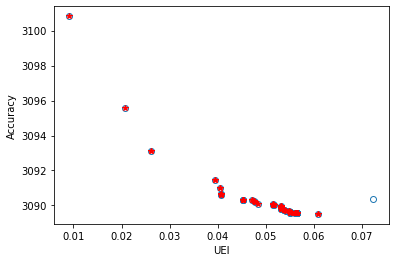

 32%|█████████████████████████▍                                                     | 322/1000 [02:19<05:40,  1.99it/s]

Force Reached!
Force Reached!


 32%|█████████████████████████▌                                                     | 324/1000 [02:20<05:10,  2.18it/s]

Force Reached!


 32%|█████████████████████████▋                                                     | 325/1000 [02:20<04:50,  2.32it/s]

Force Reached!
Force Reached!
39


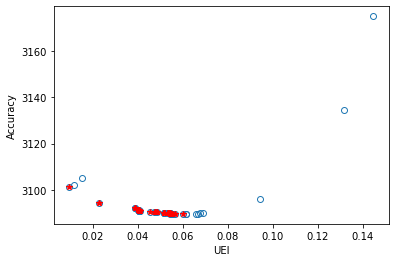

 33%|█████████████████████████▊                                                     | 327/1000 [02:21<04:50,  2.32it/s]

Force Reached!


 33%|█████████████████████████▉                                                     | 328/1000 [02:22<04:46,  2.35it/s]

Force Reached!


 33%|█████████████████████████▉                                                     | 329/1000 [02:22<04:52,  2.29it/s]

Force Reached!


 33%|██████████████████████████                                                     | 330/1000 [02:23<04:53,  2.28it/s]

Force Reached!
Force Reached!
47


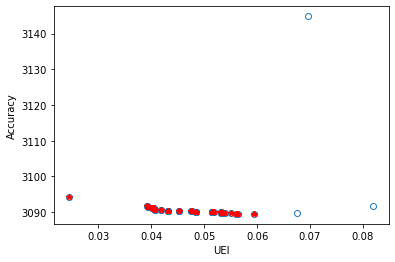

 33%|██████████████████████████▏                                                    | 332/1000 [02:23<05:07,  2.17it/s]

Force Reached!


 33%|██████████████████████████▎                                                    | 333/1000 [02:24<05:05,  2.18it/s]

Force Reached!


 33%|██████████████████████████▍                                                    | 334/1000 [02:24<04:50,  2.30it/s]

Force Reached!


 34%|██████████████████████████▍                                                    | 335/1000 [02:25<04:42,  2.35it/s]

Force Reached!
Force Reached!
48


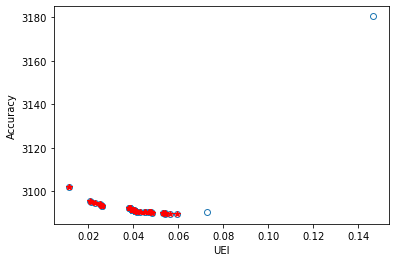

 34%|██████████████████████████▌                                                    | 337/1000 [02:26<04:56,  2.24it/s]

Force Reached!


 34%|██████████████████████████▋                                                    | 338/1000 [02:26<04:51,  2.27it/s]

Force Reached!


 34%|██████████████████████████▊                                                    | 339/1000 [02:27<04:47,  2.30it/s]

Force Reached!


 34%|██████████████████████████▊                                                    | 340/1000 [02:27<04:41,  2.34it/s]

Force Reached!
Force Reached!
48


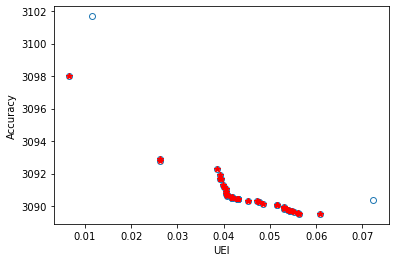

 34%|███████████████████████████                                                    | 342/1000 [02:28<04:56,  2.22it/s]

Force Reached!


 34%|███████████████████████████                                                    | 343/1000 [02:28<04:59,  2.19it/s]

Force Reached!


 34%|███████████████████████████▏                                                   | 344/1000 [02:29<04:50,  2.26it/s]

Force Reached!


 34%|███████████████████████████▎                                                   | 345/1000 [02:29<04:37,  2.36it/s]

Force Reached!
Force Reached!
47


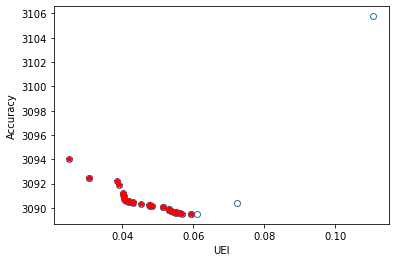

 35%|███████████████████████████▍                                                   | 348/1000 [02:30<04:02,  2.68it/s]

Force Reached!


 35%|███████████████████████████▌                                                   | 349/1000 [02:31<04:08,  2.62it/s]

Force Reached!


 35%|███████████████████████████▋                                                   | 350/1000 [02:31<04:10,  2.59it/s]

Force Reached!
Force Reached!
47


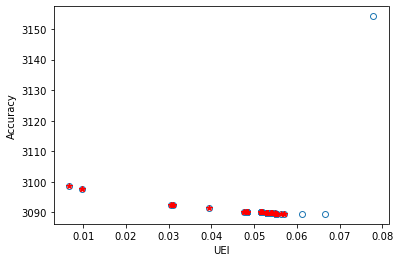

 35%|███████████████████████████▊                                                   | 352/1000 [02:32<04:29,  2.41it/s]

Force Reached!


 35%|███████████████████████████▉                                                   | 353/1000 [02:32<04:32,  2.37it/s]

Force Reached!


 35%|███████████████████████████▉                                                   | 354/1000 [02:33<04:38,  2.32it/s]

Force Reached!


 36%|████████████████████████████                                                   | 355/1000 [02:33<04:38,  2.32it/s]

Force Reached!
Force Reached!
43


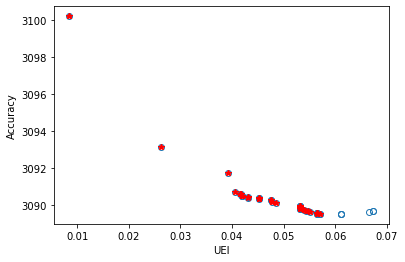

 36%|████████████████████████████▏                                                  | 357/1000 [02:34<04:37,  2.31it/s]

Force Reached!


 36%|████████████████████████████▎                                                  | 358/1000 [02:34<04:21,  2.45it/s]

Force Reached!


 36%|████████████████████████████▎                                                  | 359/1000 [02:35<04:20,  2.46it/s]

Force Reached!


 36%|████████████████████████████▍                                                  | 360/1000 [02:35<04:22,  2.44it/s]

Force Reached!
Force Reached!
43


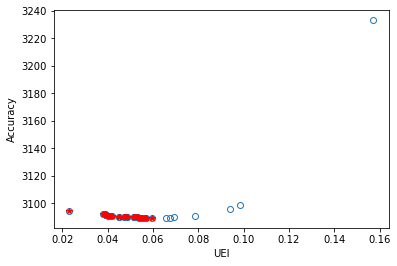

 36%|████████████████████████████▌                                                  | 362/1000 [02:36<04:23,  2.42it/s]

Force Reached!


 36%|████████████████████████████▋                                                  | 363/1000 [02:37<04:20,  2.44it/s]

Force Reached!


 36%|████████████████████████████▊                                                  | 364/1000 [02:37<04:07,  2.56it/s]

Force Reached!


 36%|████████████████████████████▊                                                  | 365/1000 [02:37<03:59,  2.65it/s]

Force Reached!
Force Reached!
40


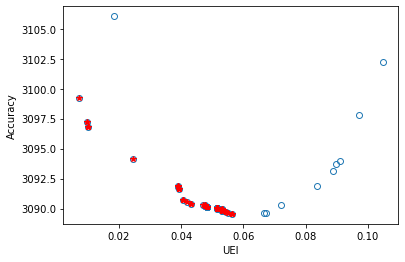

 37%|████████████████████████████▉                                                  | 367/1000 [02:38<03:57,  2.66it/s]

Force Reached!


 37%|█████████████████████████████                                                  | 368/1000 [02:38<04:01,  2.62it/s]

Force Reached!


 37%|█████████████████████████████▏                                                 | 369/1000 [02:39<04:02,  2.61it/s]

Force Reached!


 37%|█████████████████████████████▏                                                 | 370/1000 [02:39<04:05,  2.57it/s]

Force Reached!
Force Reached!
47


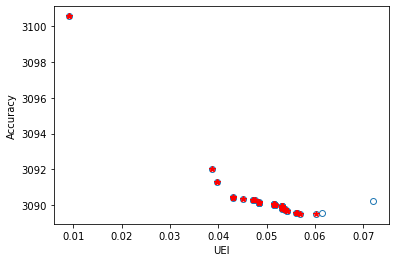

 37%|█████████████████████████████▍                                                 | 372/1000 [02:40<04:24,  2.37it/s]

Force Reached!


 37%|█████████████████████████████▍                                                 | 373/1000 [02:41<04:23,  2.38it/s]

Force Reached!


 37%|█████████████████████████████▌                                                 | 374/1000 [02:41<04:16,  2.44it/s]

Force Reached!


 38%|█████████████████████████████▋                                                 | 375/1000 [02:41<04:14,  2.46it/s]

Force Reached!
Force Reached!
47


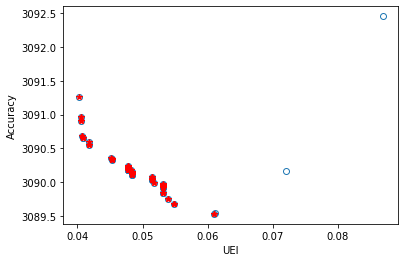

 38%|█████████████████████████████▊                                                 | 377/1000 [02:42<04:30,  2.30it/s]

Force Reached!


 38%|█████████████████████████████▊                                                 | 378/1000 [02:43<04:35,  2.26it/s]

Force Reached!


 38%|█████████████████████████████▉                                                 | 379/1000 [02:43<04:26,  2.33it/s]

Force Reached!


 38%|██████████████████████████████                                                 | 380/1000 [02:44<04:33,  2.27it/s]

Force Reached!
Force Reached!
42


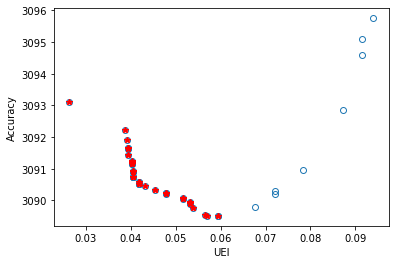

 38%|██████████████████████████████▏                                                | 382/1000 [02:44<04:19,  2.39it/s]

Force Reached!


 38%|██████████████████████████████▎                                                | 383/1000 [02:45<04:13,  2.44it/s]

Force Reached!


 38%|██████████████████████████████▎                                                | 384/1000 [02:45<04:00,  2.56it/s]

Force Reached!


 38%|██████████████████████████████▍                                                | 385/1000 [02:46<03:59,  2.57it/s]

Force Reached!
Force Reached!
45


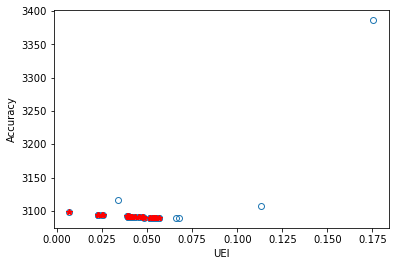

 39%|██████████████████████████████▌                                                | 387/1000 [02:46<04:12,  2.42it/s]

Force Reached!


 39%|██████████████████████████████▋                                                | 388/1000 [02:47<04:12,  2.42it/s]

Force Reached!


 39%|██████████████████████████████▋                                                | 389/1000 [02:47<04:08,  2.46it/s]

Force Reached!


 39%|██████████████████████████████▊                                                | 390/1000 [02:48<04:02,  2.52it/s]

Force Reached!
Force Reached!
48


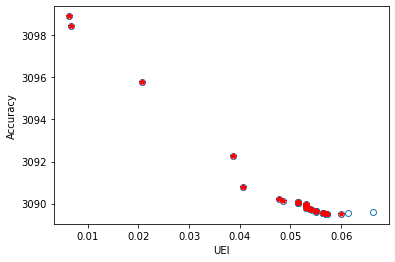

 39%|██████████████████████████████▉                                                | 392/1000 [02:48<04:16,  2.37it/s]

Force Reached!


 39%|███████████████████████████████                                                | 393/1000 [02:49<04:16,  2.36it/s]

Force Reached!


 39%|███████████████████████████████▏                                               | 394/1000 [02:49<04:10,  2.42it/s]

Force Reached!


 40%|███████████████████████████████▏                                               | 395/1000 [02:50<04:11,  2.40it/s]

Force Reached!
Force Reached!
47


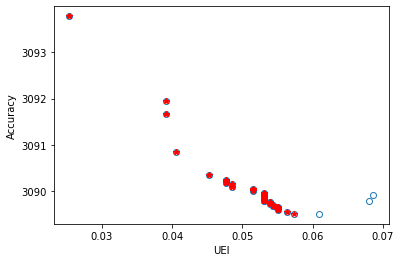

 40%|███████████████████████████████▎                                               | 397/1000 [02:51<04:12,  2.39it/s]

Force Reached!


 40%|███████████████████████████████▍                                               | 398/1000 [02:51<04:13,  2.37it/s]

Force Reached!


 40%|███████████████████████████████▌                                               | 399/1000 [02:51<04:15,  2.35it/s]

Force Reached!


 40%|███████████████████████████████▌                                               | 400/1000 [02:52<04:13,  2.37it/s]

Force Reached!
Force Reached!
46


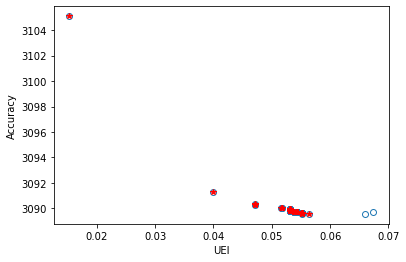

 40%|███████████████████████████████▊                                               | 402/1000 [02:53<04:18,  2.31it/s]

Force Reached!


 40%|███████████████████████████████▊                                               | 403/1000 [02:53<04:14,  2.35it/s]

Force Reached!


 40%|███████████████████████████████▉                                               | 404/1000 [02:54<04:16,  2.33it/s]

Force Reached!
Force Reached!


 40%|███████████████████████████████▉                                               | 405/1000 [02:54<04:23,  2.25it/s]

Force Reached!
45


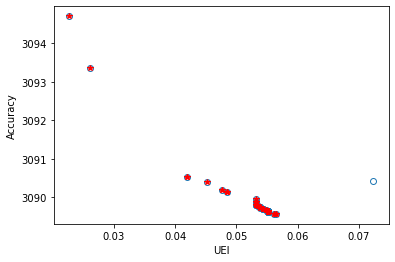

 41%|████████████████████████████████▏                                              | 407/1000 [02:55<05:13,  1.89it/s]

Force Reached!


 41%|████████████████████████████████▏                                              | 408/1000 [02:56<04:57,  1.99it/s]

Force Reached!


 41%|████████████████████████████████▎                                              | 409/1000 [02:56<04:36,  2.14it/s]

Force Reached!


 41%|████████████████████████████████▍                                              | 410/1000 [02:57<04:31,  2.17it/s]

Force Reached!
Force Reached!
41


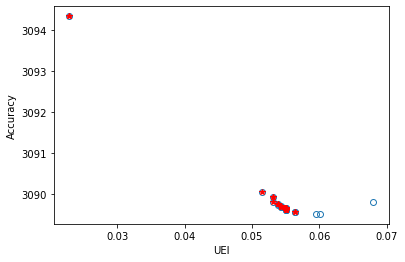

 41%|████████████████████████████████▌                                              | 412/1000 [02:58<04:28,  2.19it/s]

Force Reached!


 41%|████████████████████████████████▋                                              | 413/1000 [02:58<04:22,  2.23it/s]

Force Reached!


 41%|████████████████████████████████▋                                              | 414/1000 [02:58<04:18,  2.27it/s]

Force Reached!


 42%|████████████████████████████████▊                                              | 415/1000 [02:59<04:14,  2.30it/s]

Force Reached!
Force Reached!
48


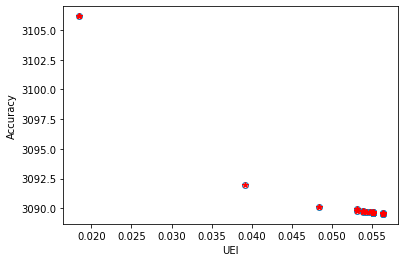

 42%|████████████████████████████████▉                                              | 417/1000 [03:00<04:16,  2.27it/s]

Force Reached!


 42%|█████████████████████████████████                                              | 418/1000 [03:00<04:12,  2.31it/s]

Force Reached!


 42%|█████████████████████████████████                                              | 419/1000 [03:01<04:07,  2.34it/s]

Force Reached!


 42%|█████████████████████████████████▏                                             | 420/1000 [03:01<04:06,  2.36it/s]

Force Reached!
Force Reached!
34


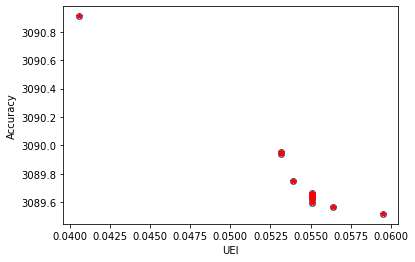

 42%|█████████████████████████████████▎                                             | 422/1000 [03:02<04:19,  2.22it/s]

Force Reached!


 42%|█████████████████████████████████▍                                             | 423/1000 [03:02<04:12,  2.29it/s]

Force Reached!


 42%|█████████████████████████████████▍                                             | 424/1000 [03:03<04:07,  2.33it/s]

Force Reached!


 42%|█████████████████████████████████▌                                             | 425/1000 [03:03<04:08,  2.31it/s]

Force Reached!
Force Reached!
45


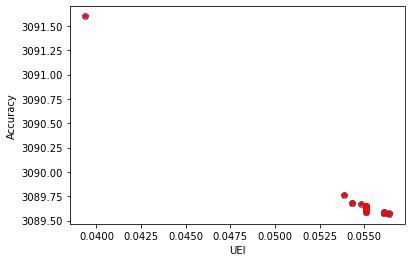

 43%|█████████████████████████████████▋                                             | 427/1000 [03:04<04:20,  2.20it/s]

Force Reached!


 43%|█████████████████████████████████▊                                             | 428/1000 [03:05<04:15,  2.24it/s]

Force Reached!


 43%|█████████████████████████████████▉                                             | 429/1000 [03:05<04:07,  2.31it/s]

Force Reached!


 43%|█████████████████████████████████▉                                             | 430/1000 [03:05<04:02,  2.35it/s]

Force Reached!
Force Reached!
50


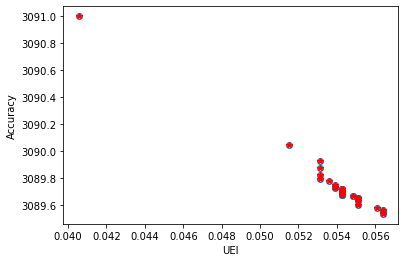

 43%|██████████████████████████████████▏                                            | 432/1000 [03:06<04:10,  2.26it/s]

Force Reached!


 43%|██████████████████████████████████▏                                            | 433/1000 [03:07<04:13,  2.24it/s]

Force Reached!


 43%|██████████████████████████████████▎                                            | 434/1000 [03:07<04:05,  2.30it/s]

Force Reached!


 44%|██████████████████████████████████▎                                            | 435/1000 [03:08<04:00,  2.35it/s]

Force Reached!
Force Reached!
43


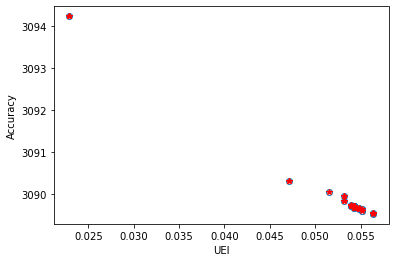

 44%|██████████████████████████████████▌                                            | 437/1000 [03:09<04:04,  2.30it/s]

Force Reached!


 44%|██████████████████████████████████▌                                            | 438/1000 [03:09<04:02,  2.32it/s]

Force Reached!


 44%|██████████████████████████████████▋                                            | 439/1000 [03:09<03:57,  2.36it/s]

Force Reached!


 44%|██████████████████████████████████▊                                            | 440/1000 [03:10<03:59,  2.34it/s]

Force Reached!
Force Reached!
42


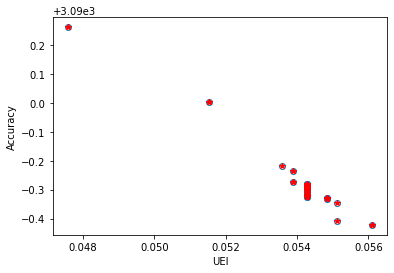

 44%|██████████████████████████████████▉                                            | 442/1000 [03:11<04:03,  2.29it/s]

Force Reached!


 44%|██████████████████████████████████▉                                            | 443/1000 [03:11<04:01,  2.31it/s]

Force Reached!


 44%|███████████████████████████████████                                            | 444/1000 [03:12<03:56,  2.35it/s]

Force Reached!


 44%|███████████████████████████████████▏                                           | 445/1000 [03:12<03:53,  2.38it/s]

Force Reached!
Force Reached!
37


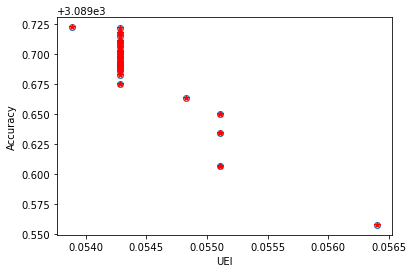

 45%|███████████████████████████████████▎                                           | 447/1000 [03:13<03:58,  2.31it/s]

Force Reached!


 45%|███████████████████████████████████▍                                           | 448/1000 [03:13<03:56,  2.34it/s]

Force Reached!


 45%|███████████████████████████████████▍                                           | 449/1000 [03:14<03:52,  2.37it/s]

Force Reached!


 45%|███████████████████████████████████▌                                           | 450/1000 [03:14<03:50,  2.39it/s]

Force Reached!
Force Reached!
22


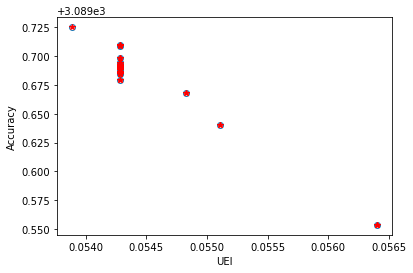

 45%|███████████████████████████████████▋                                           | 452/1000 [03:15<04:09,  2.20it/s]

Force Reached!


 45%|███████████████████████████████████▊                                           | 453/1000 [03:16<04:02,  2.26it/s]

Force Reached!


 45%|███████████████████████████████████▊                                           | 454/1000 [03:16<03:56,  2.31it/s]

Force Reached!


 46%|███████████████████████████████████▉                                           | 455/1000 [03:16<03:54,  2.33it/s]

Force Reached!
Force Reached!
27


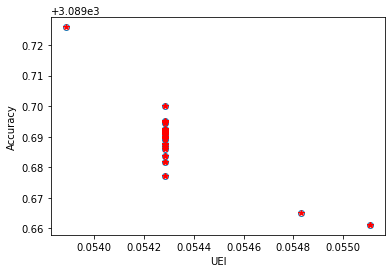

 46%|████████████████████████████████████                                           | 457/1000 [03:17<04:03,  2.23it/s]

Force Reached!


 46%|████████████████████████████████████▏                                          | 458/1000 [03:18<03:57,  2.28it/s]

Force Reached!


 46%|████████████████████████████████████▎                                          | 459/1000 [03:18<03:55,  2.30it/s]

Force Reached!


 46%|████████████████████████████████████▎                                          | 460/1000 [03:19<03:50,  2.35it/s]

Force Reached!
Force Reached!
26


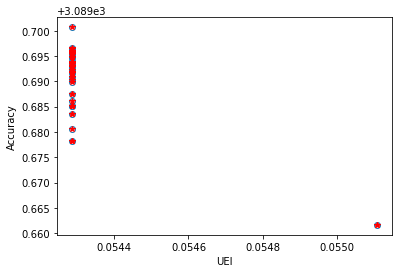

 46%|████████████████████████████████████▍                                          | 462/1000 [03:20<03:59,  2.25it/s]

Force Reached!


 46%|████████████████████████████████████▌                                          | 463/1000 [03:20<03:55,  2.28it/s]

Force Reached!


 46%|████████████████████████████████████▋                                          | 464/1000 [03:20<03:55,  2.28it/s]

Force Reached!


 46%|████████████████████████████████████▋                                          | 465/1000 [03:21<03:55,  2.27it/s]

Force Reached!
Force Reached!
28


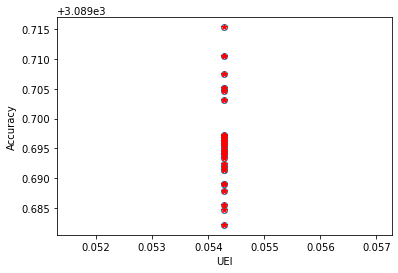

 47%|████████████████████████████████████▉                                          | 467/1000 [03:22<04:05,  2.17it/s]

Force Reached!


 47%|████████████████████████████████████▉                                          | 468/1000 [03:22<04:02,  2.19it/s]

Force Reached!
Force Reached!


 47%|█████████████████████████████████████▏                                         | 470/1000 [03:23<04:01,  2.20it/s]

Force Reached!
Force Reached!
40


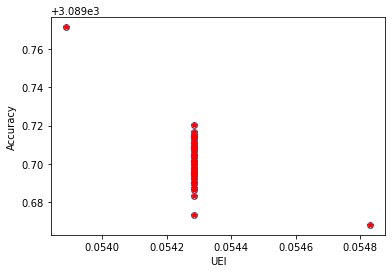

 47%|█████████████████████████████████████▎                                         | 472/1000 [03:24<04:05,  2.15it/s]

Force Reached!


 47%|█████████████████████████████████████▎                                         | 473/1000 [03:25<03:56,  2.22it/s]

Force Reached!


 47%|█████████████████████████████████████▍                                         | 474/1000 [03:25<03:57,  2.21it/s]

Force Reached!


 48%|█████████████████████████████████████▌                                         | 475/1000 [03:25<03:53,  2.24it/s]

Force Reached!
Force Reached!
42


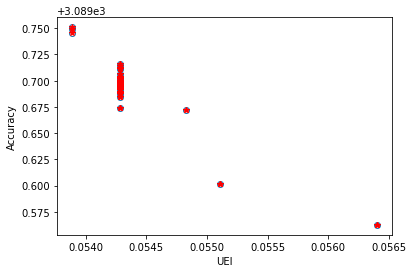

 48%|█████████████████████████████████████▋                                         | 477/1000 [03:26<04:01,  2.17it/s]

Force Reached!


 48%|█████████████████████████████████████▊                                         | 478/1000 [03:27<03:53,  2.23it/s]

Force Reached!


 48%|█████████████████████████████████████▊                                         | 479/1000 [03:27<03:47,  2.30it/s]

Force Reached!


 48%|█████████████████████████████████████▉                                         | 480/1000 [03:28<03:46,  2.29it/s]

Force Reached!
Force Reached!
30


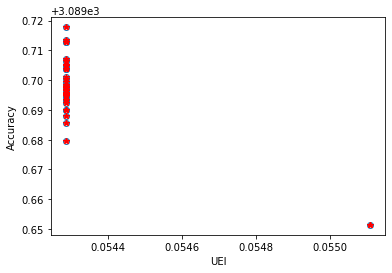

 48%|██████████████████████████████████████                                         | 482/1000 [03:29<04:01,  2.14it/s]

Force Reached!


 48%|██████████████████████████████████████▏                                        | 483/1000 [03:29<03:56,  2.19it/s]

Force Reached!


 48%|██████████████████████████████████████▏                                        | 484/1000 [03:30<03:52,  2.22it/s]

Force Reached!


 48%|██████████████████████████████████████▎                                        | 485/1000 [03:30<03:47,  2.27it/s]

Force Reached!
Force Reached!
30


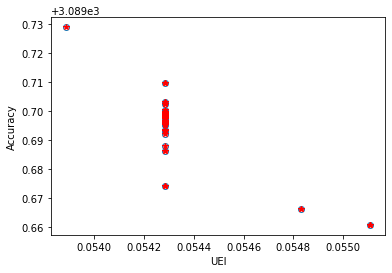

 49%|██████████████████████████████████████▍                                        | 487/1000 [03:31<03:50,  2.23it/s]

Force Reached!


 49%|██████████████████████████████████████▌                                        | 488/1000 [03:31<03:43,  2.29it/s]

Force Reached!


 49%|██████████████████████████████████████▋                                        | 489/1000 [03:32<03:42,  2.30it/s]

Force Reached!


 49%|██████████████████████████████████████▋                                        | 490/1000 [03:32<03:38,  2.34it/s]

Force Reached!
Force Reached!
48


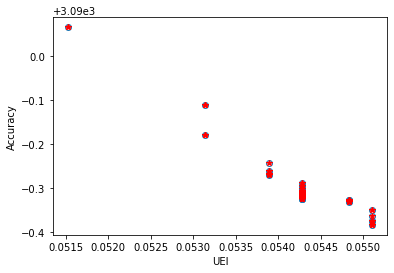

 49%|██████████████████████████████████████▊                                        | 492/1000 [03:33<03:46,  2.25it/s]

Force Reached!


 49%|██████████████████████████████████████▉                                        | 493/1000 [03:34<03:43,  2.27it/s]

Force Reached!


 49%|███████████████████████████████████████                                        | 494/1000 [03:34<03:39,  2.31it/s]

Force Reached!


 50%|███████████████████████████████████████                                        | 495/1000 [03:34<03:30,  2.40it/s]

Force Reached!
Force Reached!
50


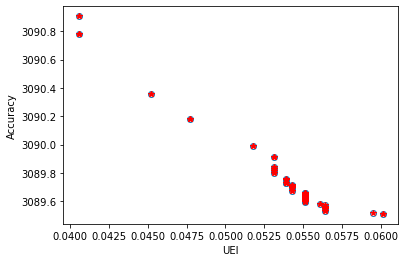

 50%|███████████████████████████████████████▎                                       | 497/1000 [03:35<03:34,  2.34it/s]

Force Reached!


 50%|███████████████████████████████████████▎                                       | 498/1000 [03:36<03:32,  2.36it/s]

Force Reached!


 50%|███████████████████████████████████████▍                                       | 499/1000 [03:36<03:27,  2.41it/s]

Force Reached!


 50%|███████████████████████████████████████▌                                       | 500/1000 [03:36<03:25,  2.44it/s]

Force Reached!
Force Reached!
45


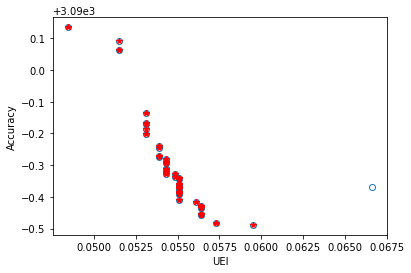

 50%|███████████████████████████████████████▋                                       | 502/1000 [03:37<03:33,  2.34it/s]

Force Reached!


 50%|███████████████████████████████████████▋                                       | 503/1000 [03:38<03:31,  2.35it/s]

Force Reached!


 50%|███████████████████████████████████████▊                                       | 504/1000 [03:38<03:28,  2.38it/s]

Force Reached!


 50%|███████████████████████████████████████▉                                       | 505/1000 [03:39<03:28,  2.38it/s]

Force Reached!
Force Reached!
42


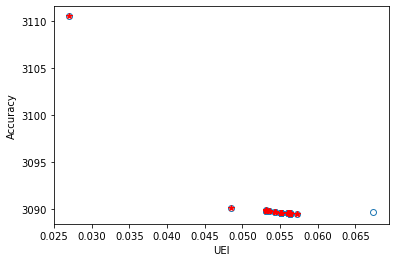

 51%|████████████████████████████████████████                                       | 507/1000 [03:40<03:33,  2.31it/s]

Force Reached!


 51%|████████████████████████████████████████▏                                      | 508/1000 [03:40<03:31,  2.33it/s]

Force Reached!


 51%|████████████████████████████████████████▏                                      | 509/1000 [03:40<03:30,  2.33it/s]

Force Reached!


 51%|████████████████████████████████████████▎                                      | 510/1000 [03:41<03:28,  2.35it/s]

Force Reached!
Force Reached!
42


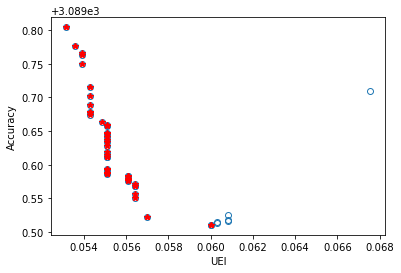

 51%|████████████████████████████████████████▍                                      | 512/1000 [03:42<03:27,  2.35it/s]

Force Reached!


 51%|████████████████████████████████████████▌                                      | 513/1000 [03:42<03:21,  2.42it/s]

Force Reached!


 51%|████████████████████████████████████████▌                                      | 514/1000 [03:42<03:20,  2.43it/s]

Force Reached!


 52%|████████████████████████████████████████▋                                      | 515/1000 [03:43<03:21,  2.41it/s]

Force Reached!
Force Reached!
50


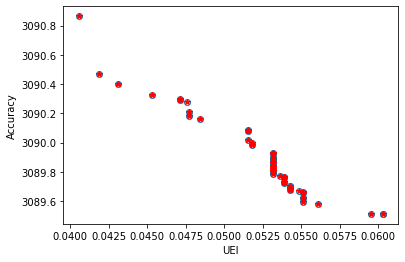

 52%|████████████████████████████████████████▊                                      | 517/1000 [03:44<03:32,  2.27it/s]

Force Reached!


 52%|████████████████████████████████████████▉                                      | 518/1000 [03:44<03:24,  2.36it/s]

Force Reached!


 52%|█████████████████████████████████████████                                      | 519/1000 [03:45<03:22,  2.38it/s]

Force Reached!


 52%|█████████████████████████████████████████                                      | 520/1000 [03:45<03:29,  2.29it/s]

Force Reached!
Force Reached!
46


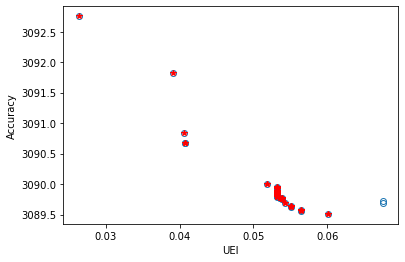

 52%|█████████████████████████████████████████▏                                     | 522/1000 [03:46<03:31,  2.27it/s]

Force Reached!


 52%|█████████████████████████████████████████▎                                     | 523/1000 [03:46<03:27,  2.29it/s]

Force Reached!


 52%|█████████████████████████████████████████▍                                     | 524/1000 [03:47<03:25,  2.32it/s]

Force Reached!


 52%|█████████████████████████████████████████▍                                     | 525/1000 [03:47<03:22,  2.35it/s]

Force Reached!
Force Reached!
45


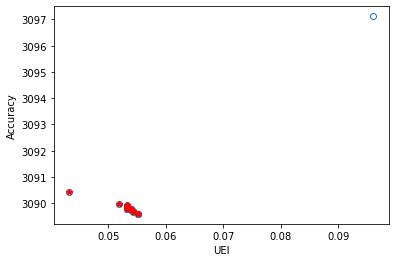

 53%|█████████████████████████████████████████▋                                     | 527/1000 [03:48<03:28,  2.26it/s]

Force Reached!


 53%|█████████████████████████████████████████▋                                     | 528/1000 [03:49<03:26,  2.28it/s]

Force Reached!


 53%|█████████████████████████████████████████▊                                     | 529/1000 [03:49<03:22,  2.32it/s]

Force Reached!


 53%|█████████████████████████████████████████▊                                     | 530/1000 [03:49<03:22,  2.32it/s]

Force Reached!
Force Reached!
43


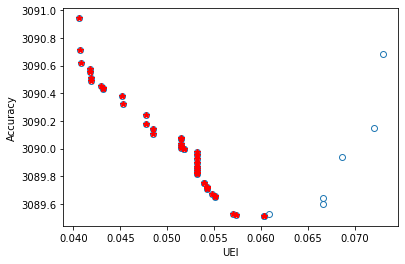

 53%|██████████████████████████████████████████                                     | 532/1000 [03:50<03:24,  2.29it/s]

Force Reached!


 53%|██████████████████████████████████████████                                     | 533/1000 [03:51<03:17,  2.37it/s]

Force Reached!


 53%|██████████████████████████████████████████▏                                    | 534/1000 [03:51<02:57,  2.62it/s]

Force Reached!


 54%|██████████████████████████████████████████▎                                    | 535/1000 [03:51<02:58,  2.60it/s]

Force Reached!
Force Reached!
45


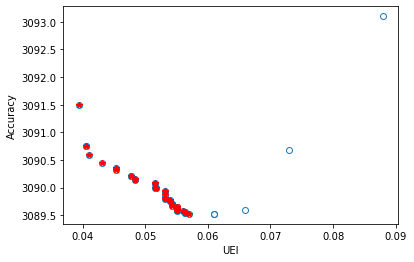

 54%|██████████████████████████████████████████▍                                    | 537/1000 [03:52<03:07,  2.47it/s]

Force Reached!


 54%|██████████████████████████████████████████▌                                    | 538/1000 [03:53<03:06,  2.48it/s]

Force Reached!


 54%|██████████████████████████████████████████▌                                    | 539/1000 [03:53<03:09,  2.44it/s]

Force Reached!


 54%|██████████████████████████████████████████▋                                    | 540/1000 [03:54<03:13,  2.38it/s]

Force Reached!
Force Reached!
47


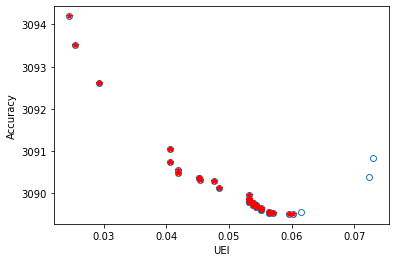

 54%|██████████████████████████████████████████▊                                    | 542/1000 [03:55<03:25,  2.22it/s]

Force Reached!


 54%|██████████████████████████████████████████▉                                    | 543/1000 [03:55<03:25,  2.23it/s]

Force Reached!


 54%|██████████████████████████████████████████▉                                    | 544/1000 [03:55<03:14,  2.35it/s]

Force Reached!


 55%|███████████████████████████████████████████                                    | 545/1000 [03:56<03:12,  2.36it/s]

Force Reached!
Force Reached!
34


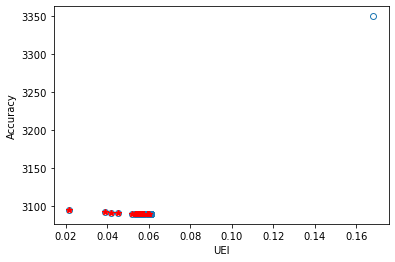

 55%|███████████████████████████████████████████▏                                   | 547/1000 [03:57<03:05,  2.44it/s]

Force Reached!


 55%|███████████████████████████████████████████▎                                   | 548/1000 [03:57<02:47,  2.70it/s]

Force Reached!


 55%|███████████████████████████████████████████▎                                   | 549/1000 [03:57<02:46,  2.71it/s]

Force Reached!


 55%|███████████████████████████████████████████▍                                   | 550/1000 [03:58<02:43,  2.75it/s]

Force Reached!
Force Reached!
45


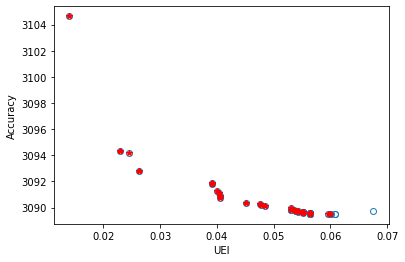

 55%|███████████████████████████████████████████▌                                   | 552/1000 [03:58<02:56,  2.53it/s]

Force Reached!


 55%|███████████████████████████████████████████▊                                   | 554/1000 [03:59<02:34,  2.89it/s]

Force Reached!


 56%|███████████████████████████████████████████▊                                   | 555/1000 [03:59<02:31,  2.94it/s]

Force Reached!
Force Reached!
42


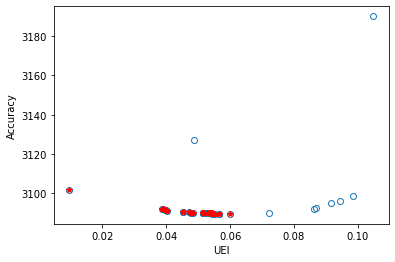

 56%|████████████████████████████████████████████                                   | 557/1000 [04:00<02:55,  2.53it/s]

Force Reached!


 56%|████████████████████████████████████████████                                   | 558/1000 [04:01<03:00,  2.45it/s]

Force Reached!


 56%|████████████████████████████████████████████▏                                  | 559/1000 [04:01<03:05,  2.38it/s]

Force Reached!


 56%|████████████████████████████████████████████▏                                  | 560/1000 [04:02<03:03,  2.39it/s]

Force Reached!
Force Reached!
44


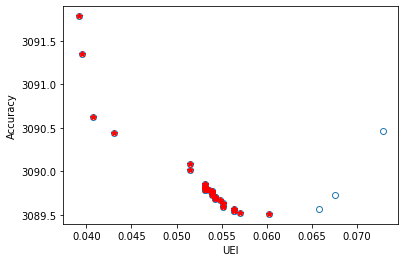

 56%|████████████████████████████████████████████▍                                  | 562/1000 [04:02<03:14,  2.25it/s]

Force Reached!


 56%|████████████████████████████████████████████▍                                  | 563/1000 [04:03<03:15,  2.24it/s]

Force Reached!


 56%|████████████████████████████████████████████▌                                  | 564/1000 [04:03<03:13,  2.26it/s]

Force Reached!


 56%|████████████████████████████████████████████▋                                  | 565/1000 [04:04<03:07,  2.32it/s]

Force Reached!
Force Reached!
47


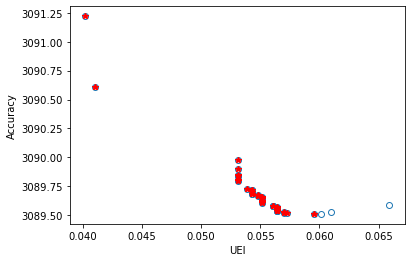

 57%|████████████████████████████████████████████▊                                  | 567/1000 [04:05<03:13,  2.24it/s]

Force Reached!


 57%|████████████████████████████████████████████▊                                  | 568/1000 [04:05<03:10,  2.27it/s]

Force Reached!


 57%|████████████████████████████████████████████▉                                  | 569/1000 [04:06<03:05,  2.32it/s]

Force Reached!


 57%|█████████████████████████████████████████████                                  | 570/1000 [04:06<03:03,  2.34it/s]

Force Reached!
Force Reached!
47


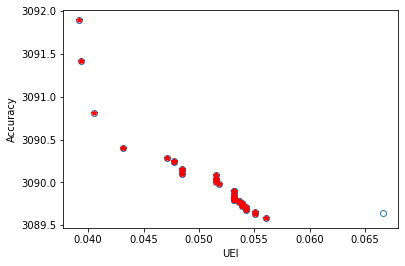

 57%|█████████████████████████████████████████████▏                                 | 572/1000 [04:07<03:12,  2.23it/s]

Force Reached!


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [04:07<03:09,  2.26it/s]

Force Reached!


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [04:08<03:11,  2.23it/s]

Force Reached!


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [04:08<03:07,  2.27it/s]

Force Reached!
Force Reached!
50


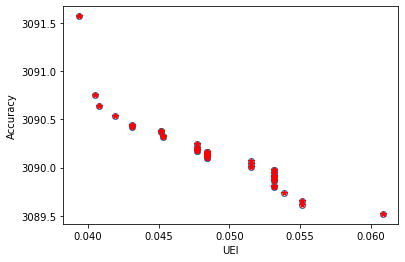

 58%|█████████████████████████████████████████████▌                                 | 577/1000 [04:09<03:10,  2.22it/s]

Force Reached!


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [04:10<03:02,  2.31it/s]

Force Reached!


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [04:10<02:58,  2.36it/s]

Force Reached!


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [04:10<02:52,  2.43it/s]

Force Reached!
Force Reached!
48


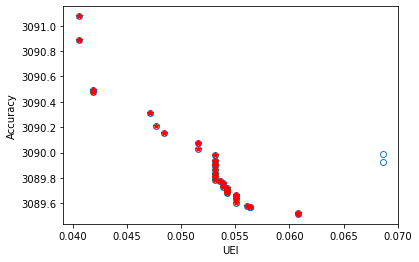

 58%|█████████████████████████████████████████████▉                                 | 582/1000 [04:11<03:00,  2.32it/s]

Force Reached!


 58%|██████████████████████████████████████████████                                 | 583/1000 [04:12<02:57,  2.36it/s]

Force Reached!


 58%|██████████████████████████████████████████████▏                                | 584/1000 [04:12<02:57,  2.35it/s]

Force Reached!


 58%|██████████████████████████████████████████████▏                                | 585/1000 [04:13<02:58,  2.32it/s]

Force Reached!
Force Reached!
47


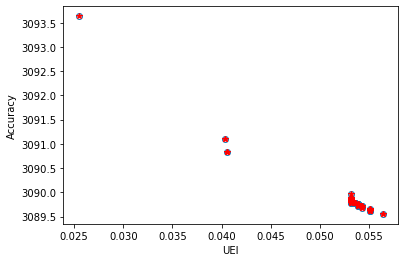

 59%|██████████████████████████████████████████████▎                                | 587/1000 [04:14<03:04,  2.24it/s]

Force Reached!


 59%|██████████████████████████████████████████████▍                                | 588/1000 [04:14<03:02,  2.26it/s]

Force Reached!


 59%|██████████████████████████████████████████████▌                                | 589/1000 [04:14<03:00,  2.28it/s]

Force Reached!


 59%|██████████████████████████████████████████████▌                                | 590/1000 [04:15<02:56,  2.32it/s]

Force Reached!
Force Reached!
45


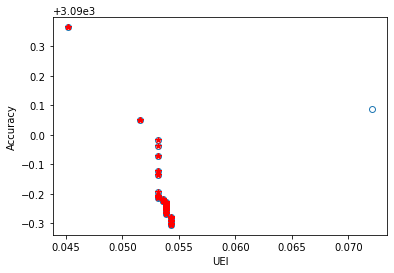

 59%|██████████████████████████████████████████████▊                                | 592/1000 [04:16<03:07,  2.17it/s]

Force Reached!


 59%|██████████████████████████████████████████████▊                                | 593/1000 [04:16<03:06,  2.18it/s]

Force Reached!


 59%|██████████████████████████████████████████████▉                                | 594/1000 [04:17<03:03,  2.22it/s]

Force Reached!


 60%|███████████████████████████████████████████████                                | 595/1000 [04:17<03:01,  2.23it/s]

Force Reached!
Force Reached!
41


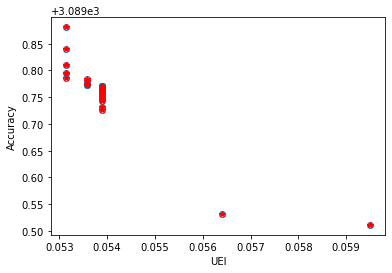

 60%|███████████████████████████████████████████████▏                               | 597/1000 [04:18<03:10,  2.11it/s]

Force Reached!


 60%|███████████████████████████████████████████████▏                               | 598/1000 [04:19<03:04,  2.18it/s]

Force Reached!


 60%|███████████████████████████████████████████████▎                               | 599/1000 [04:19<03:01,  2.20it/s]

Force Reached!


 60%|███████████████████████████████████████████████▍                               | 600/1000 [04:19<03:00,  2.21it/s]

Force Reached!
Force Reached!
48


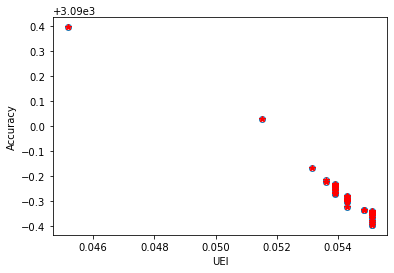

 60%|███████████████████████████████████████████████▌                               | 602/1000 [04:21<03:13,  2.05it/s]

Force Reached!


 60%|███████████████████████████████████████████████▋                               | 603/1000 [04:21<03:06,  2.12it/s]

Force Reached!


 60%|███████████████████████████████████████████████▋                               | 604/1000 [04:21<03:01,  2.18it/s]

Force Reached!


 60%|███████████████████████████████████████████████▊                               | 605/1000 [04:22<02:59,  2.20it/s]

Force Reached!
Force Reached!
42


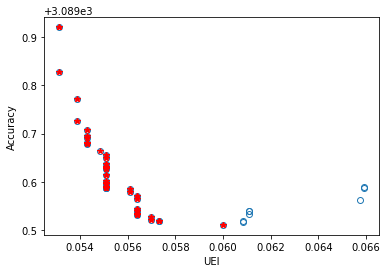

 61%|███████████████████████████████████████████████▉                               | 607/1000 [04:23<02:52,  2.28it/s]

Force Reached!


 61%|████████████████████████████████████████████████                               | 608/1000 [04:23<02:48,  2.33it/s]

Force Reached!


 61%|████████████████████████████████████████████████                               | 609/1000 [04:23<02:42,  2.40it/s]

Force Reached!


 61%|████████████████████████████████████████████████▏                              | 610/1000 [04:24<02:45,  2.35it/s]

Force Reached!
Force Reached!
44


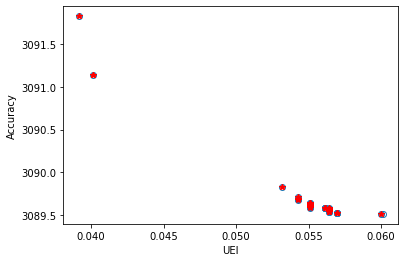

 61%|████████████████████████████████████████████████▎                              | 612/1000 [04:25<02:55,  2.21it/s]

Force Reached!


 61%|████████████████████████████████████████████████▍                              | 613/1000 [04:25<02:53,  2.23it/s]

Force Reached!


 61%|████████████████████████████████████████████████▌                              | 614/1000 [04:26<02:39,  2.42it/s]

Force Reached!


 62%|████████████████████████████████████████████████▌                              | 615/1000 [04:26<02:46,  2.31it/s]

Force Reached!
Force Reached!
47


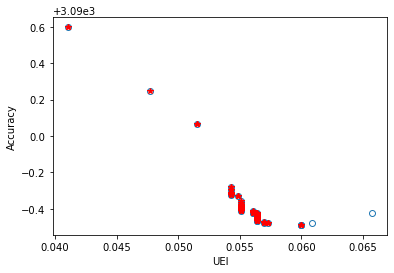

 62%|████████████████████████████████████████████████▋                              | 617/1000 [04:27<02:58,  2.15it/s]

Force Reached!


 62%|████████████████████████████████████████████████▊                              | 618/1000 [04:28<03:03,  2.08it/s]

Force Reached!


 62%|████████████████████████████████████████████████▉                              | 619/1000 [04:28<03:04,  2.07it/s]

Force Reached!


 62%|████████████████████████████████████████████████▉                              | 620/1000 [04:29<02:55,  2.17it/s]

Force Reached!
Force Reached!
40


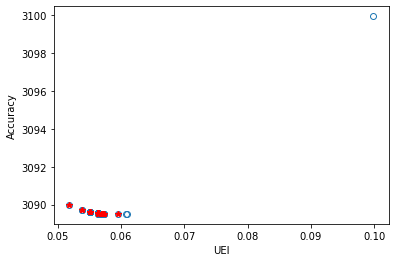

 62%|█████████████████████████████████████████████████▏                             | 622/1000 [04:30<03:06,  2.02it/s]

Force Reached!


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [04:30<03:05,  2.03it/s]

Force Reached!


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [04:31<02:59,  2.09it/s]

Force Reached!


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [04:31<02:55,  2.14it/s]

Force Reached!
Force Reached!
38


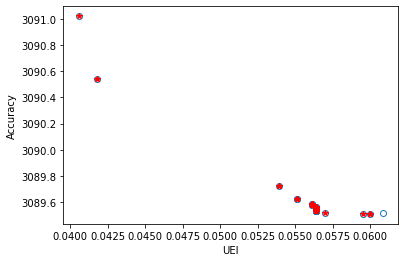

 63%|█████████████████████████████████████████████████▌                             | 627/1000 [04:32<03:00,  2.07it/s]

Force Reached!


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [04:33<02:58,  2.08it/s]

Force Reached!


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [04:33<02:53,  2.14it/s]

Force Reached!


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [04:33<02:51,  2.16it/s]

Force Reached!
Force Reached!
42


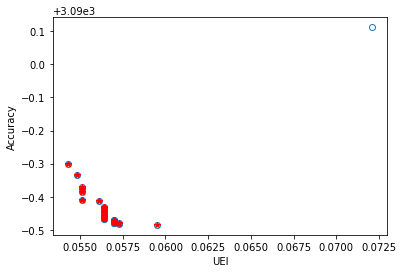

 63%|█████████████████████████████████████████████████▉                             | 632/1000 [04:34<02:51,  2.15it/s]

Force Reached!


 63%|██████████████████████████████████████████████████                             | 633/1000 [04:35<02:47,  2.18it/s]

Force Reached!


 63%|██████████████████████████████████████████████████                             | 634/1000 [04:35<02:38,  2.31it/s]

Force Reached!


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [04:35<02:24,  2.52it/s]

Force Reached!
Force Reached!
40


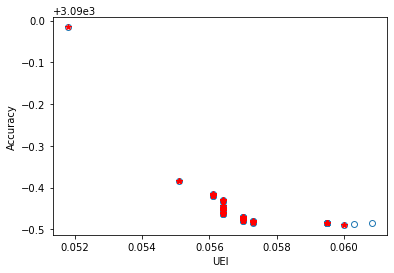

 64%|██████████████████████████████████████████████████▎                            | 637/1000 [04:36<02:41,  2.25it/s]

Force Reached!


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [04:37<02:37,  2.30it/s]

Force Reached!


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [04:37<02:29,  2.41it/s]

Force Reached!


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [04:38<02:31,  2.38it/s]

Force Reached!
Force Reached!
40


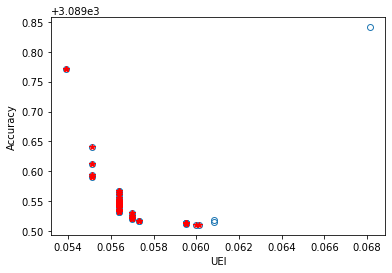

 64%|██████████████████████████████████████████████████▋                            | 641/1000 [04:38<02:43,  2.20it/s]

Force Reached!


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [04:39<02:53,  2.05it/s]

Force Reached!


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [04:40<02:34,  2.30it/s]

Force Reached!


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [04:40<02:23,  2.47it/s]

Force Reached!
Force Reached!
35


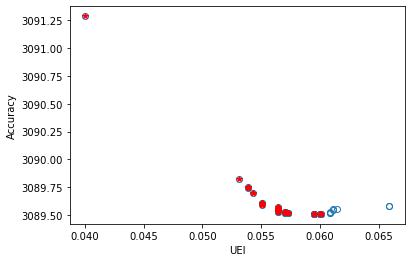

 65%|███████████████████████████████████████████████████                            | 647/1000 [04:41<02:27,  2.39it/s]

Force Reached!


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [04:41<02:28,  2.37it/s]

Force Reached!


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [04:42<02:33,  2.29it/s]

Force Reached!


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [04:42<02:36,  2.24it/s]

Force Reached!
Force Reached!
39


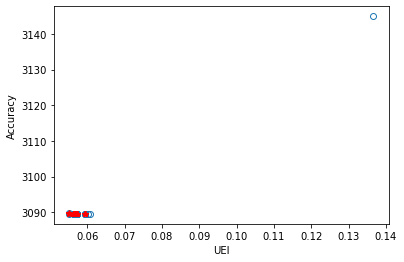

 65%|███████████████████████████████████████████████████▌                           | 652/1000 [04:43<02:40,  2.17it/s]

Force Reached!


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [04:44<02:36,  2.22it/s]

Force Reached!


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [04:44<02:34,  2.24it/s]

Force Reached!


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [04:44<02:37,  2.19it/s]

Force Reached!
Force Reached!
47


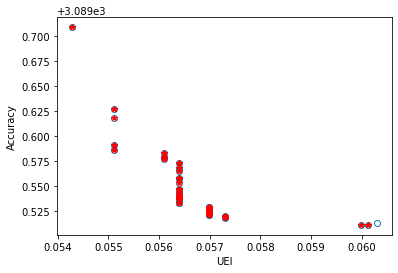

 66%|███████████████████████████████████████████████████▉                           | 657/1000 [04:46<02:43,  2.09it/s]

Force Reached!


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [04:46<02:38,  2.16it/s]

Force Reached!


 66%|████████████████████████████████████████████████████                           | 659/1000 [04:46<02:36,  2.18it/s]

Force Reached!
Force Reached!


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [04:47<02:38,  2.15it/s]

Force Reached!
41


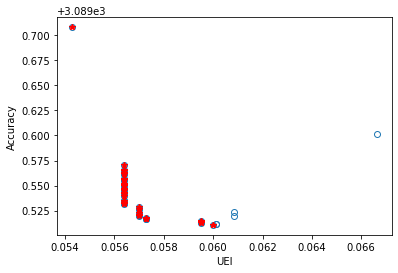

 66%|████████████████████████████████████████████████████▎                          | 662/1000 [04:48<02:43,  2.07it/s]

Force Reached!


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [04:48<02:26,  2.30it/s]

Force Reached!


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [04:49<02:26,  2.29it/s]

Force Reached!


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [04:49<02:24,  2.31it/s]

Force Reached!
Force Reached!
44


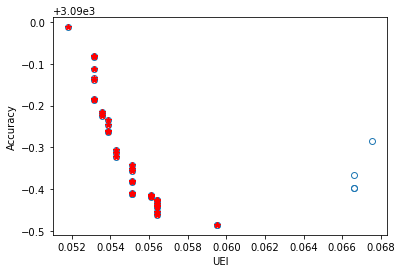

 67%|████████████████████████████████████████████████████▋                          | 667/1000 [04:50<02:22,  2.34it/s]

Force Reached!


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [04:50<02:24,  2.30it/s]

Force Reached!


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [04:51<02:27,  2.25it/s]

Force Reached!


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [04:51<02:29,  2.21it/s]

Force Reached!
Force Reached!
43


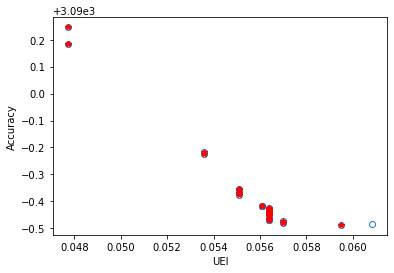

 67%|█████████████████████████████████████████████████████                          | 672/1000 [04:52<02:43,  2.00it/s]

Force Reached!


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [04:53<02:35,  2.10it/s]

Force Reached!


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [04:53<02:30,  2.16it/s]

Force Reached!


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [04:54<02:30,  2.15it/s]

Force Reached!
Force Reached!
32


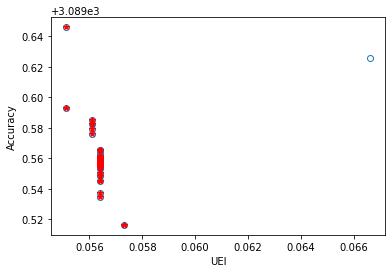

 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [04:54<02:49,  1.91it/s]

Force Reached!


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [04:56<02:51,  1.87it/s]

Force Reached!


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [04:56<02:44,  1.95it/s]

Force Reached!


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [04:56<02:39,  2.01it/s]

Force Reached!
Force Reached!
27


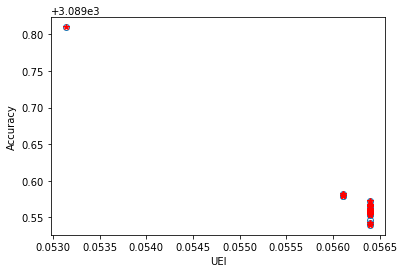

 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [04:58<02:43,  1.94it/s]

Force Reached!


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [04:58<02:34,  2.05it/s]

Force Reached!


 68%|██████████████████████████████████████████████████████                         | 684/1000 [04:58<02:31,  2.08it/s]

Force Reached!


 68%|██████████████████████████████████████████████████████                         | 685/1000 [04:59<02:31,  2.08it/s]

Force Reached!
Force Reached!
21


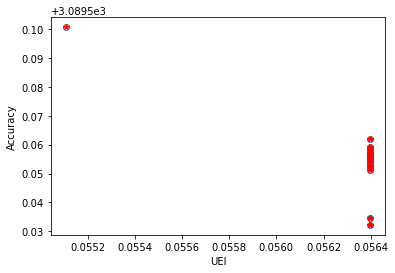

 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [05:00<02:31,  2.07it/s]

Force Reached!


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [05:00<02:32,  2.05it/s]

Force Reached!


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [05:01<02:27,  2.11it/s]

Force Reached!


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [05:01<02:25,  2.13it/s]

Force Reached!
Force Reached!
34


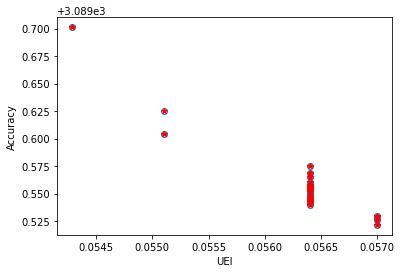

 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [05:02<02:29,  2.06it/s]

Force Reached!


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [05:03<02:31,  2.03it/s]

Force Reached!


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [05:03<02:27,  2.07it/s]

Force Reached!


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [05:04<02:25,  2.10it/s]

Force Reached!
Force Reached!
24


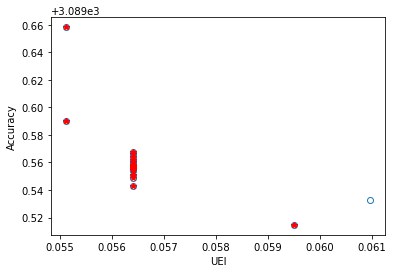

 70%|███████████████████████████████████████████████████████                        | 697/1000 [05:05<02:28,  2.04it/s]

Force Reached!


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [05:05<02:23,  2.10it/s]

Force Reached!


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [05:06<02:22,  2.12it/s]

Force Reached!


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [05:06<02:20,  2.14it/s]

Force Reached!
Force Reached!
35


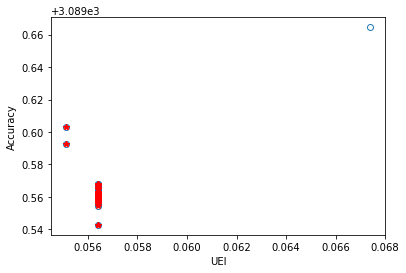

 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [05:07<02:28,  2.01it/s]

Force Reached!


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [05:08<02:23,  2.07it/s]

Force Reached!


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [05:08<02:20,  2.11it/s]

Force Reached!


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [05:09<02:20,  2.10it/s]

Force Reached!
Force Reached!
37


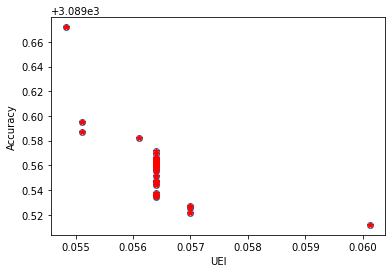

 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [05:09<02:30,  1.96it/s]

Force Reached!


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [05:10<02:23,  2.03it/s]

Force Reached!


 71%|████████████████████████████████████████████████████████                       | 709/1000 [05:11<02:21,  2.06it/s]

Force Reached!


 71%|████████████████████████████████████████████████████████                       | 710/1000 [05:11<02:17,  2.11it/s]

Force Reached!
Force Reached!
43


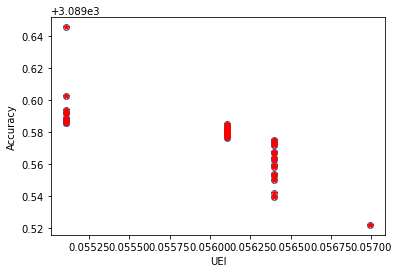

 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [05:12<02:25,  1.98it/s]

Force Reached!


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [05:13<02:21,  2.03it/s]

Force Reached!


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [05:13<02:22,  2.01it/s]

Force Reached!


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [05:14<02:18,  2.06it/s]

Force Reached!
Force Reached!
41


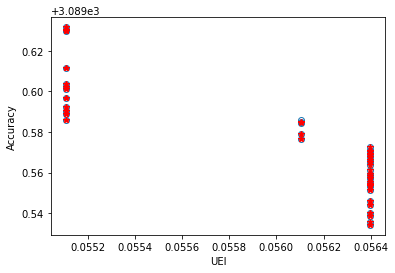

 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [05:15<02:20,  2.01it/s]

Force Reached!


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [05:15<02:17,  2.06it/s]

Force Reached!


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [05:15<02:11,  2.13it/s]

Force Reached!


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [05:16<02:08,  2.18it/s]

Force Reached!
Force Reached!
46


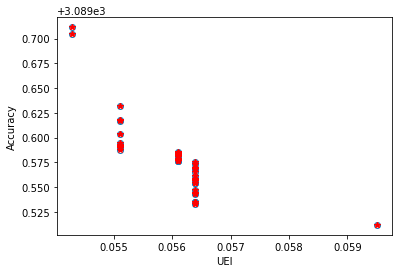

 72%|█████████████████████████████████████████████████████████                      | 722/1000 [05:17<02:15,  2.05it/s]

Force Reached!


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [05:17<02:11,  2.11it/s]

Force Reached!


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [05:18<02:08,  2.14it/s]

Force Reached!


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [05:18<02:07,  2.16it/s]

Force Reached!
Force Reached!
39


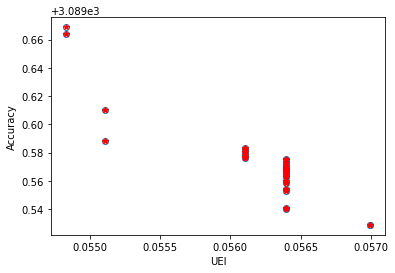

 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [05:19<02:11,  2.08it/s]

Force Reached!


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [05:20<02:07,  2.13it/s]

Force Reached!


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [05:20<02:05,  2.15it/s]

Force Reached!


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [05:21<02:04,  2.16it/s]

Force Reached!
Force Reached!
38


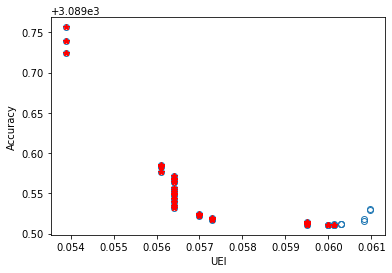

 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [05:22<01:58,  2.27it/s]

Force Reached!


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [05:22<01:49,  2.44it/s]

Force Reached!


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [05:22<01:48,  2.46it/s]

Force Reached!


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [05:23<01:47,  2.47it/s]

Force Reached!
Force Reached!
42


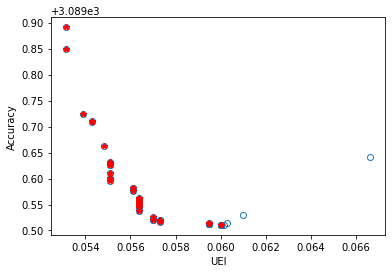

 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [05:24<01:56,  2.26it/s]

Force Reached!


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [05:24<01:51,  2.34it/s]

Force Reached!


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [05:24<01:52,  2.32it/s]

Force Reached!


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [05:25<01:51,  2.33it/s]

Force Reached!
Force Reached!
44


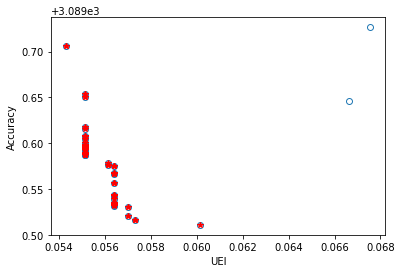

 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [05:26<01:57,  2.19it/s]

Force Reached!


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [05:26<01:57,  2.18it/s]

Force Reached!


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [05:27<01:53,  2.25it/s]

Force Reached!


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [05:27<01:51,  2.28it/s]

Force Reached!
Force Reached!
44


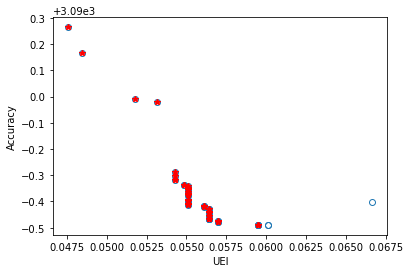

 75%|███████████████████████████████████████████████████████████                    | 747/1000 [05:28<01:56,  2.16it/s]

Force Reached!


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [05:29<01:52,  2.25it/s]

Force Reached!


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [05:29<01:46,  2.36it/s]

Force Reached!


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [05:29<01:47,  2.32it/s]

Force Reached!
Force Reached!
45


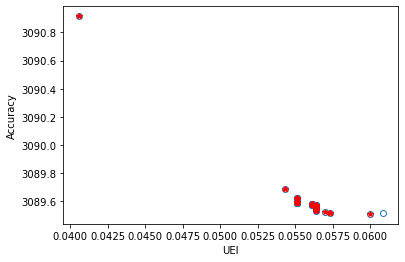

 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [05:30<01:57,  2.10it/s]

Force Reached!


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [05:31<01:48,  2.27it/s]

Force Reached!


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [05:31<01:46,  2.30it/s]

Force Reached!


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [05:32<01:53,  2.15it/s]

Force Reached!
Force Reached!
34


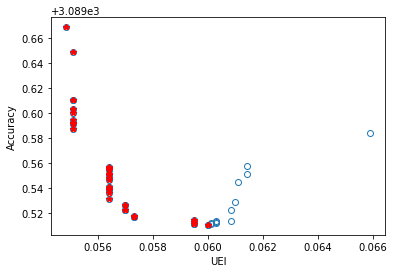

 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [05:33<01:51,  2.18it/s]

Force Reached!


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [05:33<01:48,  2.22it/s]

Force Reached!


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [05:34<01:49,  2.20it/s]

Force Reached!


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [05:34<01:42,  2.35it/s]

Force Reached!
Force Reached!
44


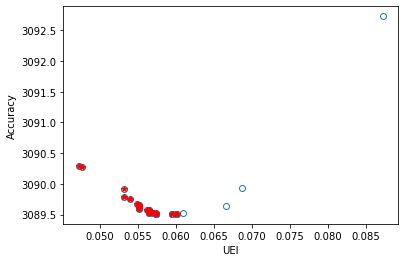

 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [05:35<01:49,  2.16it/s]

Force Reached!


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [05:35<01:45,  2.25it/s]

Force Reached!


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [05:36<01:47,  2.21it/s]

Force Reached!


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [05:36<01:42,  2.29it/s]

Force Reached!
Force Reached!
36


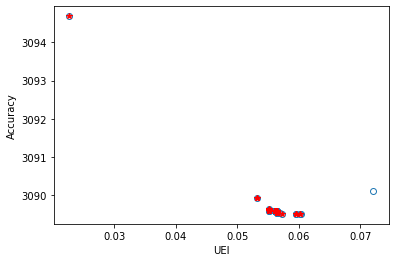

 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [05:37<01:50,  2.10it/s]

Force Reached!


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [05:38<01:48,  2.13it/s]

Force Reached!


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [05:38<01:44,  2.20it/s]

Force Reached!


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [05:39<01:43,  2.21it/s]

Force Reached!
Force Reached!
44


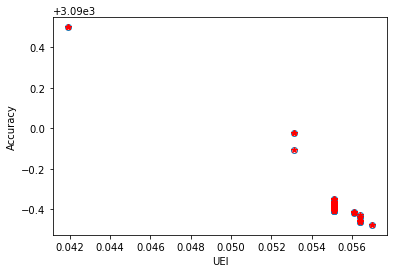

 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [05:40<01:46,  2.15it/s]

Force Reached!


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [05:40<01:44,  2.18it/s]

Force Reached!


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [05:40<01:39,  2.27it/s]

Force Reached!


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [05:41<01:40,  2.25it/s]

Force Reached!
Force Reached!
40


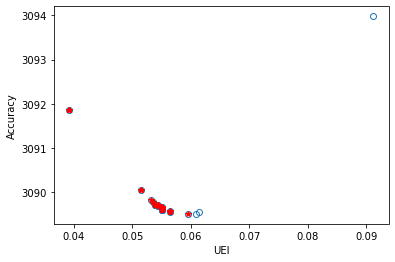

 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [05:42<01:38,  2.26it/s]

Force Reached!


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [05:42<01:37,  2.28it/s]

Force Reached!


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [05:43<01:39,  2.23it/s]

Force Reached!


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [05:43<01:36,  2.28it/s]

Force Reached!
Force Reached!
47


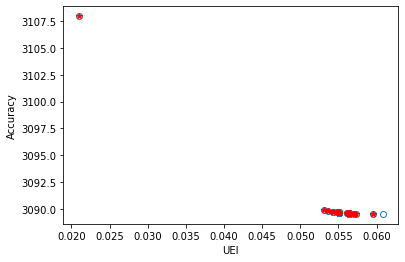

 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [05:44<01:38,  2.21it/s]

Force Reached!


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [05:45<01:36,  2.24it/s]

Force Reached!


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [05:45<01:35,  2.25it/s]

Force Reached!


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [05:45<01:33,  2.31it/s]

Force Reached!
Force Reached!
48


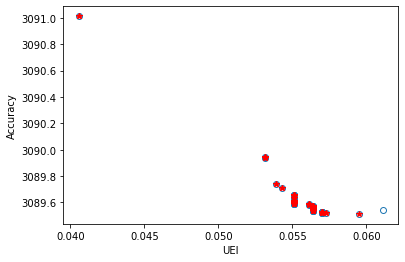

 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [05:46<01:35,  2.22it/s]

Force Reached!


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [05:47<01:33,  2.27it/s]

Force Reached!


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [05:47<01:31,  2.30it/s]

Force Reached!


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [05:48<01:30,  2.31it/s]

Force Reached!
Force Reached!
49


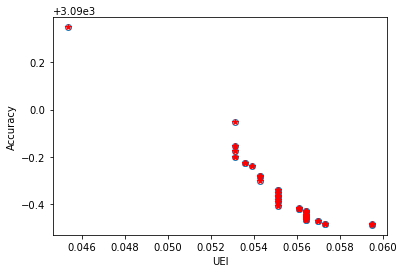

 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [05:49<01:30,  2.29it/s]

Force Reached!


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [05:49<01:28,  2.34it/s]

Force Reached!


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [05:49<01:28,  2.33it/s]

Force Reached!


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [05:50<01:26,  2.38it/s]

Force Reached!
Force Reached!
45


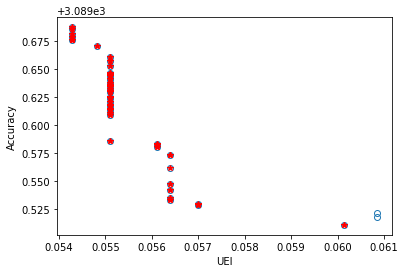

 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [05:51<01:29,  2.28it/s]

Force Reached!


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [05:51<01:27,  2.30it/s]

Force Reached!


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [05:52<01:26,  2.31it/s]

Force Reached!


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [05:52<01:26,  2.32it/s]

Force Reached!
Force Reached!
38


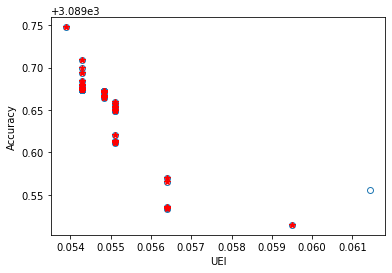

 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [05:53<01:28,  2.24it/s]

Force Reached!
Force Reached!


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [05:53<01:33,  2.12it/s]

Force Reached!


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [05:54<01:37,  2.01it/s]

Force Reached!


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [05:55<01:40,  1.94it/s]

Force Reached!
40


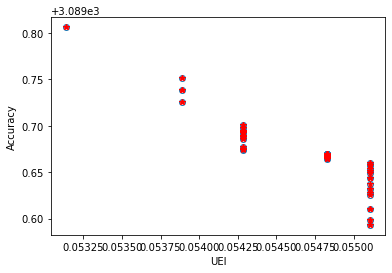

 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [05:56<01:40,  1.91it/s]

Force Reached!


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [05:56<01:38,  1.95it/s]

Force Reached!


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [05:57<01:33,  2.04it/s]

Force Reached!


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [05:57<01:30,  2.09it/s]

Force Reached!
Force Reached!
35


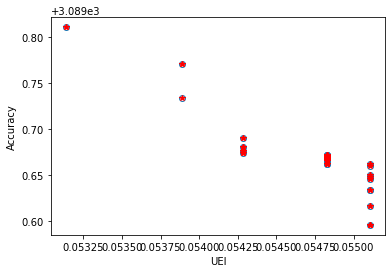

 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [05:58<01:28,  2.13it/s]

Force Reached!


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [05:58<01:25,  2.17it/s]

Force Reached!


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [05:59<01:23,  2.22it/s]

Force Reached!


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [05:59<01:21,  2.26it/s]

Force Reached!
Force Reached!
37


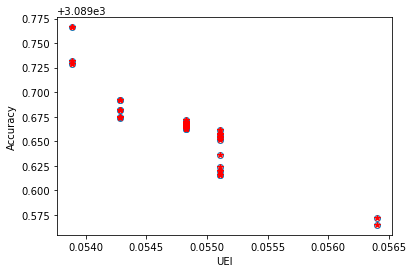

 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [06:00<01:27,  2.09it/s]

Force Reached!


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [06:01<01:25,  2.12it/s]

Force Reached!


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [06:01<01:24,  2.13it/s]

Force Reached!


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [06:02<01:26,  2.07it/s]

Force Reached!
Force Reached!
38


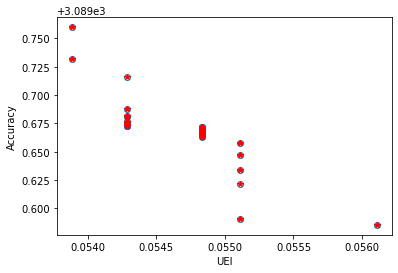

 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [06:03<01:26,  2.05it/s]

Force Reached!


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [06:03<01:23,  2.12it/s]

Force Reached!


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [06:04<01:19,  2.20it/s]

Force Reached!
Force Reached!


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [06:04<01:23,  2.10it/s]

Force Reached!
36


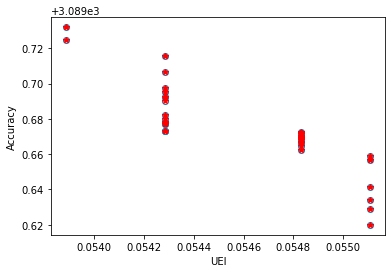

 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [06:05<01:32,  1.88it/s]

Force Reached!


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [06:06<02:09,  1.34it/s]

Force Reached!


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [06:07<02:14,  1.28it/s]

Force Reached!


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [06:08<02:13,  1.28it/s]

Force Reached!


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [06:08<02:08,  1.33it/s]

Force Reached!
41


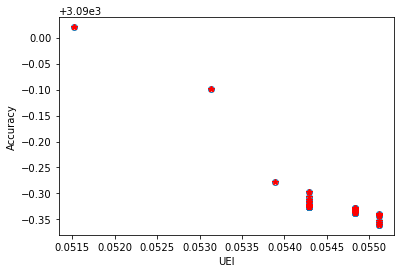

 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [06:09<02:14,  1.26it/s]

Force Reached!


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [06:10<02:09,  1.30it/s]

Force Reached!


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [06:11<02:03,  1.35it/s]

Force Reached!


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [06:11<02:02,  1.36it/s]

Force Reached!


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [06:12<02:02,  1.35it/s]

Force Reached!
32


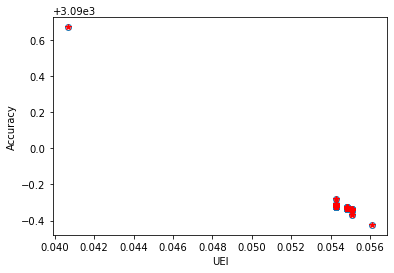

 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [06:13<02:13,  1.23it/s]

Force Reached!


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [06:14<02:10,  1.25it/s]

Force Reached!


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [06:15<02:06,  1.28it/s]

Force Reached!


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [06:15<01:54,  1.41it/s]

Force Reached!


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [06:16<01:47,  1.50it/s]

Force Reached!
35


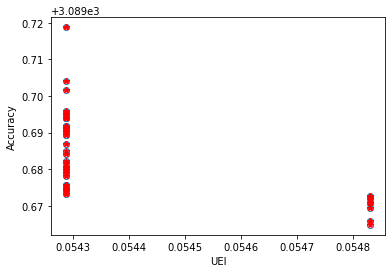

 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [06:17<01:38,  1.60it/s]

Force Reached!


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [06:17<01:34,  1.67it/s]

Force Reached!


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [06:18<01:30,  1.73it/s]

Force Reached!


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [06:19<01:28,  1.76it/s]

Force Reached!
Force Reached!
44


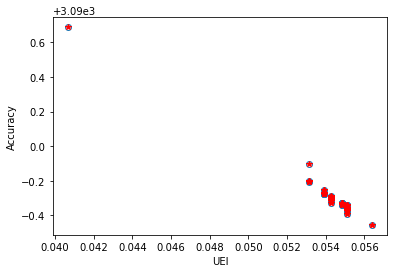

 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [06:20<01:21,  1.88it/s]

Force Reached!


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [06:20<01:16,  2.00it/s]

Force Reached!


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [06:20<01:12,  2.08it/s]

Force Reached!


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [06:21<01:09,  2.16it/s]

Force Reached!
Force Reached!
47


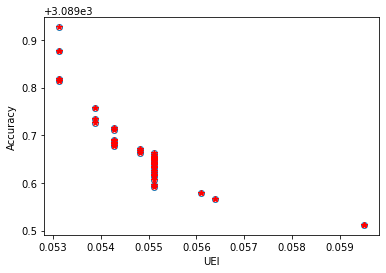

 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [06:21<01:13,  2.02it/s]

Force Reached!


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [06:22<01:14,  1.99it/s]

Force Reached!


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [06:23<01:15,  1.94it/s]

Force Reached!
Force Reached!


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [06:24<01:15,  1.92it/s]

Force Reached!
42


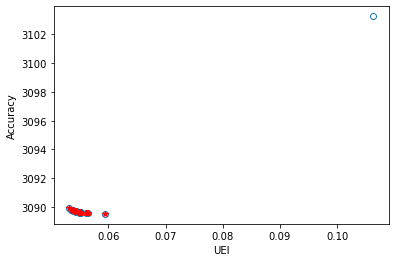

 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [06:25<01:12,  1.97it/s]

Force Reached!


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [06:25<01:08,  2.07it/s]

Force Reached!


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [06:25<01:05,  2.16it/s]

Force Reached!


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [06:26<01:03,  2.19it/s]

Force Reached!
Force Reached!
38


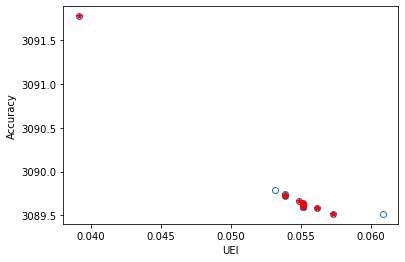

 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [06:27<01:02,  2.20it/s]

Force Reached!


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [06:27<01:02,  2.18it/s]

Force Reached!


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [06:28<01:03,  2.15it/s]

Force Reached!


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [06:28<01:01,  2.18it/s]

Force Reached!
Force Reached!
42


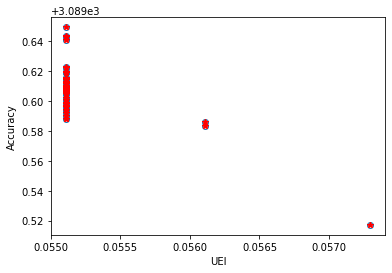

 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [06:29<01:03,  2.10it/s]

Force Reached!


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [06:30<01:00,  2.18it/s]

Force Reached!


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [06:30<00:59,  2.22it/s]

Force Reached!


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [06:30<00:57,  2.25it/s]

Force Reached!
Force Reached!
46


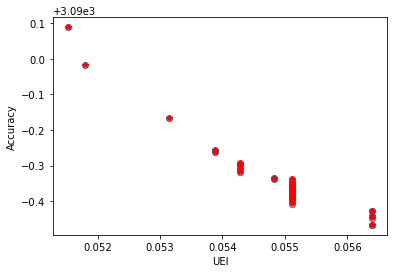

 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [06:31<00:58,  2.20it/s]

Force Reached!


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [06:32<00:57,  2.22it/s]

Force Reached!


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [06:32<00:55,  2.26it/s]

Force Reached!


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [06:33<00:55,  2.27it/s]

Force Reached!
Force Reached!
44


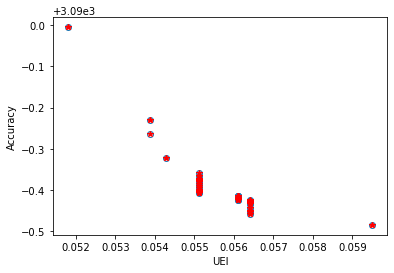

 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [06:34<00:55,  2.21it/s]

Force Reached!


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [06:34<00:54,  2.25it/s]

Force Reached!


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [06:34<00:53,  2.26it/s]

Force Reached!


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [06:35<00:52,  2.29it/s]

Force Reached!
Force Reached!
46


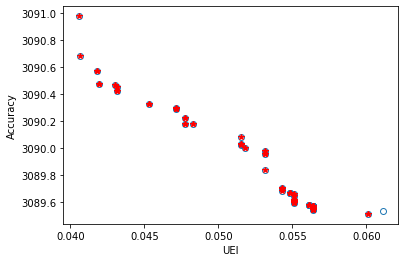

 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [06:36<00:50,  2.35it/s]

Force Reached!


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [06:36<00:49,  2.35it/s]

Force Reached!
Force Reached!


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [06:37<00:54,  2.12it/s]

Force Reached!


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [06:37<00:57,  2.00it/s]

Force Reached!
47


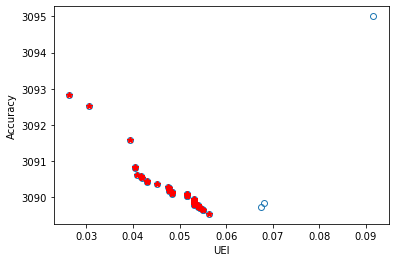

 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [06:38<01:01,  1.85it/s]

Force Reached!


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [06:39<00:54,  2.04it/s]

Force Reached!


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [06:39<00:48,  2.30it/s]

Force Reached!


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [06:40<00:47,  2.31it/s]

Force Reached!
Force Reached!
45


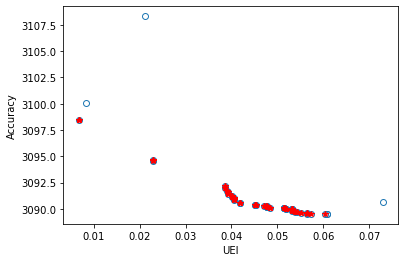

 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [06:41<00:51,  2.09it/s]

Force Reached!


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [06:41<00:49,  2.15it/s]

Force Reached!


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [06:42<00:49,  2.12it/s]

Force Reached!


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [06:42<00:43,  2.40it/s]

Force Reached!
Force Reached!
37


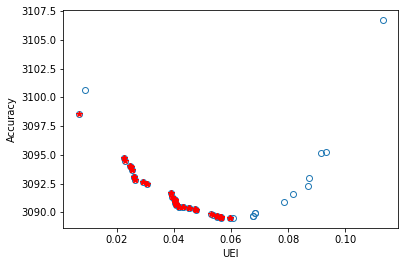

 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [06:43<00:45,  2.29it/s]

Force Reached!


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [06:43<00:43,  2.35it/s]

Force Reached!


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [06:44<00:44,  2.26it/s]

Force Reached!


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [06:44<00:43,  2.30it/s]

Force Reached!
Force Reached!
40


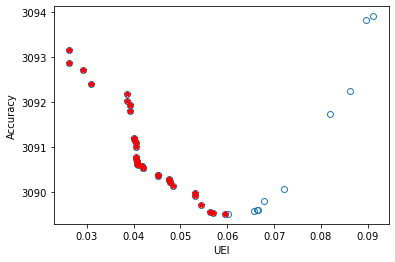

 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [06:45<00:40,  2.40it/s]

Force Reached!


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [06:45<00:40,  2.41it/s]

Force Reached!


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [06:46<00:38,  2.51it/s]

Force Reached!


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [06:46<00:38,  2.47it/s]

Force Reached!
Force Reached!
43


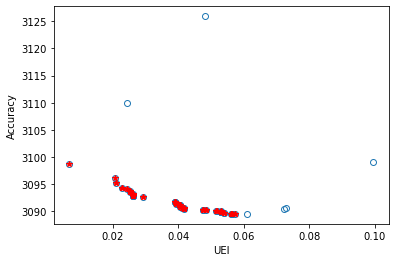

 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [06:47<00:39,  2.38it/s]

Force Reached!


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [06:47<00:38,  2.42it/s]

Force Reached!


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [06:48<00:39,  2.31it/s]

Force Reached!


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [06:48<00:38,  2.34it/s]

Force Reached!
Force Reached!
48


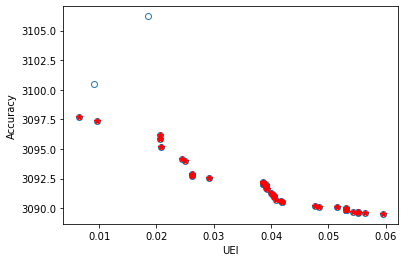

 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [06:49<00:38,  2.27it/s]

Force Reached!


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [06:50<00:37,  2.33it/s]

Force Reached!


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [06:50<00:38,  2.24it/s]

Force Reached!


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [06:51<00:37,  2.25it/s]

Force Reached!
Force Reached!
48


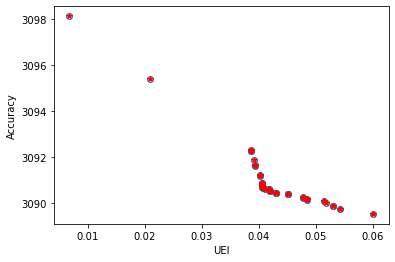

 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [06:52<00:38,  2.17it/s]

Force Reached!


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [06:52<00:37,  2.20it/s]

Force Reached!


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [06:52<00:36,  2.21it/s]

Force Reached!


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [06:53<00:36,  2.20it/s]

Force Reached!
Force Reached!
49


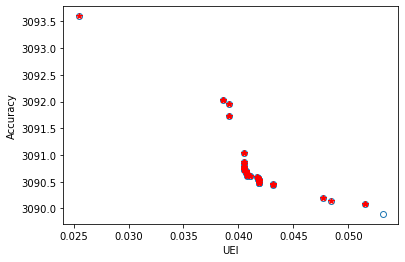

 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [06:54<00:37,  2.10it/s]

Force Reached!
Force Reached!


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [06:54<00:39,  1.97it/s]

Force Reached!


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [06:56<00:38,  1.93it/s]

Force Reached!
Force Reached!
49


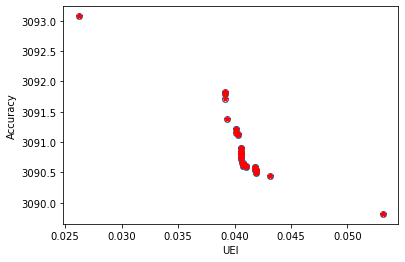

 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [06:56<00:39,  1.87it/s]

Force Reached!


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [06:57<00:39,  1.85it/s]

Force Reached!


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [06:58<00:42,  1.67it/s]

Force Reached!


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [06:58<00:39,  1.78it/s]

Force Reached!
Force Reached!
49


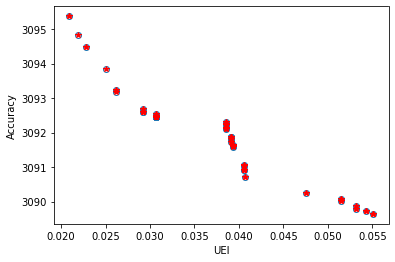

 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [06:59<00:39,  1.74it/s]

Force Reached!


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [07:00<00:38,  1.79it/s]

Force Reached!


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [07:00<00:37,  1.77it/s]

Force Reached!


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [07:01<00:34,  1.88it/s]

Force Reached!
Force Reached!
48


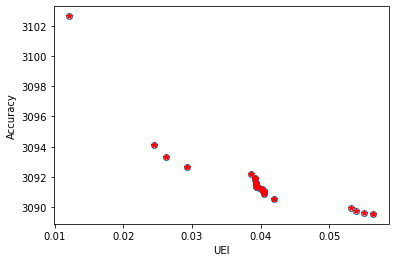

 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [07:02<00:33,  1.89it/s]

Force Reached!


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [07:03<00:30,  2.03it/s]

Force Reached!


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [07:03<00:29,  2.06it/s]

Force Reached!


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [07:04<00:28,  2.13it/s]

Force Reached!
Force Reached!
46


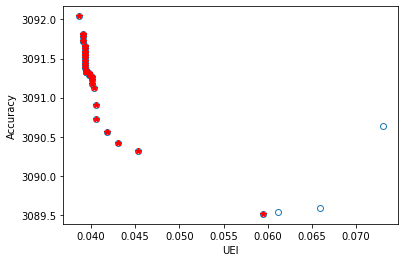

 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [07:05<00:29,  1.99it/s]

Force Reached!


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [07:05<00:27,  2.04it/s]

Force Reached!


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [07:06<00:26,  2.09it/s]

Force Reached!


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [07:06<00:26,  2.11it/s]

Force Reached!
Force Reached!
47


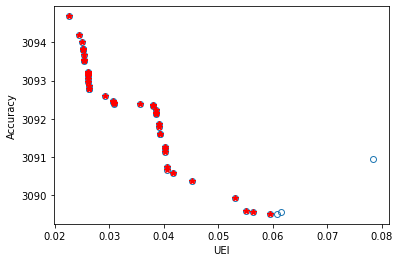

 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [07:07<00:25,  2.08it/s]

Force Reached!


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [07:07<00:23,  2.18it/s]

Force Reached!


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [07:08<00:23,  2.20it/s]

Force Reached!


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [07:08<00:21,  2.28it/s]

Force Reached!
Force Reached!
40


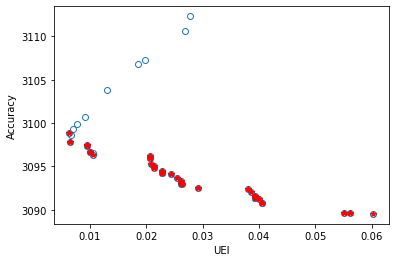

 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [07:09<00:21,  2.22it/s]

Force Reached!


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [07:10<00:19,  2.40it/s]

Force Reached!


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [07:10<00:17,  2.60it/s]

Force Reached!


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [07:10<00:17,  2.62it/s]

Force Reached!
Force Reached!
33


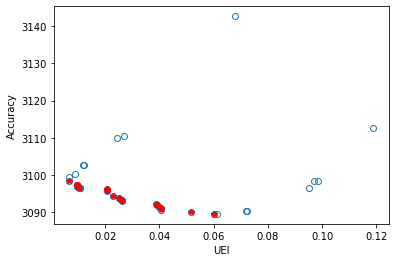

 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [07:11<00:17,  2.43it/s]

Force Reached!


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [07:12<00:16,  2.51it/s]

Force Reached!


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [07:12<00:15,  2.62it/s]

Force Reached!


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [07:12<00:15,  2.65it/s]

Force Reached!
Force Reached!
44


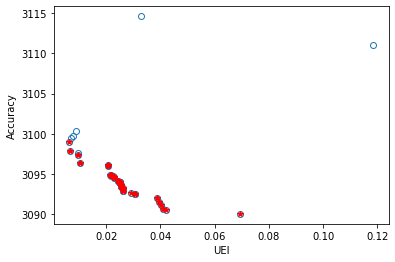

 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [07:13<00:16,  2.32it/s]

Force Reached!


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [07:14<00:16,  2.29it/s]

Force Reached!


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [07:14<00:15,  2.31it/s]

Force Reached!


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [07:15<00:15,  2.28it/s]

Force Reached!
Force Reached!
48


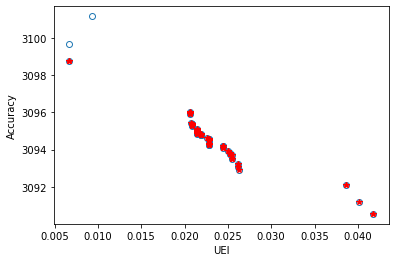

 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [07:16<00:15,  2.14it/s]

Force Reached!


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [07:16<00:14,  2.15it/s]

Force Reached!


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [07:16<00:14,  2.15it/s]

Force Reached!


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [07:17<00:14,  2.09it/s]

Force Reached!
Force Reached!
49


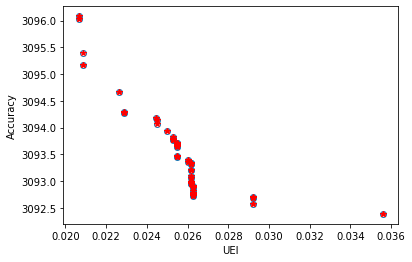

 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [07:18<00:13,  2.08it/s]

Force Reached!


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [07:18<00:12,  2.11it/s]

Force Reached!


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [07:19<00:12,  2.11it/s]

Force Reached!


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [07:19<00:12,  2.06it/s]

Force Reached!
Force Reached!
50


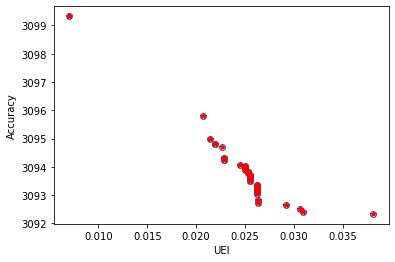

 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [07:20<00:11,  2.06it/s]

Force Reached!


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [07:21<00:10,  2.03it/s]

Force Reached!


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [07:21<00:10,  2.07it/s]

Force Reached!


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [07:22<00:09,  2.12it/s]

Force Reached!
Force Reached!
50


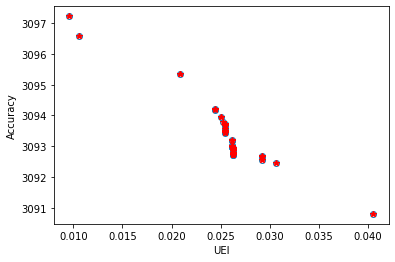

 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [07:23<00:08,  2.05it/s]

Force Reached!


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [07:23<00:08,  2.09it/s]

Force Reached!


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [07:24<00:07,  2.05it/s]

Force Reached!


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [07:24<00:07,  2.07it/s]

Force Reached!
Force Reached!
50


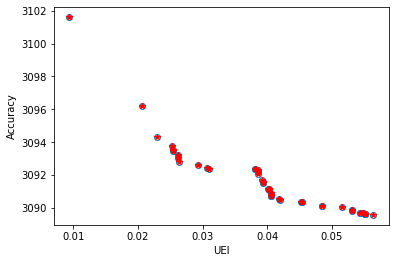

 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [07:25<00:05,  2.18it/s]

Force Reached!


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [07:26<00:05,  2.17it/s]

Force Reached!


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [07:26<00:05,  2.16it/s]

Force Reached!


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [07:27<00:04,  2.16it/s]

Force Reached!
Force Reached!
47


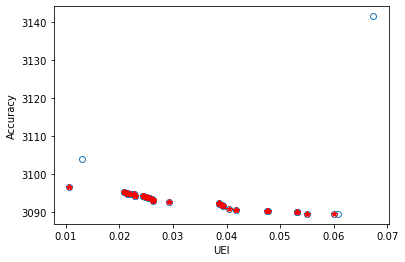

 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [07:28<00:03,  2.13it/s]

Force Reached!


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [07:28<00:03,  2.05it/s]

Force Reached!
Force Reached!


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [07:29<00:03,  1.87it/s]

Force Reached!


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [07:29<00:02,  1.82it/s]

Force Reached!
47


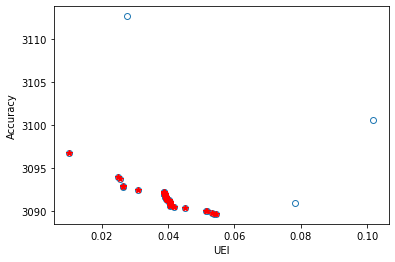

100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [07:30<00:01,  1.84it/s]

Force Reached!


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [07:31<00:01,  1.98it/s]

Force Reached!


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [07:31<00:00,  2.06it/s]

Force Reached!


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:32<00:00,  2.21it/s]

Force Reached!


In [113]:
from tqdm import tqdm
maxIteration = 1000
n_particle = 50
maxNRep = 100
w_coef = 0.5
beta = 1
gamma = 1
nGrid = 20
nObj = 2
alpha = 0.1
wdamping = 0.95
dim = Xtrain.shape[1]

particles = [Particle() for p in range(n_particle)]

for i in range(n_particle):
    #initialize the position of each particle
    w,b = initialize_network([dim,5,1])
    y_hat = feedforward(Xtrain.T,w,b).T  
    particles[i].position = w,b
    
    #initialize the speed of each particle
    particles[i].velocity = initialize_velocity([dim,5,1])
    
    #evaluate each particle
    y_pred = feedforward(Xtrain.T,w,b).T
    best_ba,best_us = evaluate(y_train,y_pred.ravel(),Xtrain[:,-1])
    particles[i].cost = [best_ba,best_us]
    
    #initialize memory of each particle (used as a guide to travel through search space)
    particles[i].best_position = particles[i].position
    
    #initialize best eval
    particles[i].best_cost = particles[i].cost
    
    #initialize isDominated to False
    particles[i].isDominated = False

particles = determineDomination(particles)
# Store the positions of the particles that represent nondominated vectors in the repository 
repos = [item for item in particles if item.isDominated == False]
# Create Grid
grid = createGrid(repos,nGrid,alpha,nObj)
# Find Index of each particle in the repo
for i in range(len(repos)):
    repos[i] = findIndex(repos[0],grid,nObj,nGrid)
    
for iteration in tqdm(range(maxIteration)):
    # for each particle
    for i in range(n_particle):
        leader = selectLeader(repos,beta)
        w,b = randomized_network([dim,5,1])
        randweight = np.asarray((w,b))
        particles[i].velocity = w_coef*np.asarray(particles[i].velocity) \
                        +  2.8*random.uniform(0,1) * (np.asarray(particles[i].best_position) - np.asarray(particles[i].position)) \
                        +  1.2*random.uniform(0,1) * (np.asarray(leader.position) - np.asarray(particles[i].position))
        
#         print(particles[i].velocity)
        
        #compute new poisition by adding the speed produced from selecting leader
        particles[i].position = np.asarray(particles[i].position) + np.asarray(particles[i].velocity)
        
        #evaluate each particle
        w_copy = particles[i].position.ravel()[:2]
        b_copy = particles[i].position.ravel()[-2]
        y_pred = feedforward(Xtrain.T,w_copy,b_copy).T
        best_ba,best_us = evaluate(y_train,y_pred.ravel(),Xtrain[:,-1])
        particles[i].cost = [best_ba,best_us]
    
        if Dominates(particles[i].cost, particles[i].best_cost):
            particles[i].best_position = particles[i].position
            particles[i].best_cost = particles[i].cost
        else:
            if np.random.rand() > 0.5:
                particles[i].best_position = particles[i].position
                particles[i].best_cost = particles[i].cost
                
    repos = repos + particles
    repos = determineDomination(repos)
    repos = [item for item in repos if item.isDominated == False]
    grid = createGrid(repos,nGrid,alpha,nObj)
    for i in range(len(repos)):
        repos[i] = findIndex(repos[i],grid,nObj,nGrid)
    
    if len(repos) > maxNRep:
        
#         if len(set([tuple(item.cost) for item in repos])) < 5:
        print('Force Reached!')
        extra = (len(repos) - maxNRep)
        for i in range(int(extra)):
            repos = deleteOneMember(repos,gamma)
            for particles_ in repos:
                if Dominates(particles_.cost, particles_.best_cost):
                    particles_.best_position = particles_.position
                    particles_.best_cost = particles_.cost
            else:
                if np.random.rand() > 0.5:
                    particles_.best_position = particles_.position
                    particles_.best_cost = particles_.cost
            repos = determineDomination(repos)
            repos = [item for item in repos if item.isDominated == False]
#         else:
#             print('MaxRep Limit Reached!')
#             extra = (len(repos) - maxNRep)
#             for i in range(int(extra)):
#                 repos = deleteOneMember(repos,gamma)
    
    
        
    
    if iteration % 5 == 0:
        plt.clf()
        particlesCost = np.reshape( [item.cost for item in particles],newshape=(n_particle,2))
        reposCost = [item.cost for item in repos]
        print(len(set([tuple(item.cost) for item in repos])))
        reposCost = np.reshape(reposCost, newshape=(len(reposCost),2))
        plt.plot(particlesCost[:,1],particlesCost[:,0],'o',mfc='none')
        plt.plot(reposCost[:,1], reposCost[:,0],'r*')
        plt.ylabel('Accuracy')
        plt.xlabel('UEI')
        plt.draw()
        plt.pause(0.0000000001)
        
        
    
    w_coef = w_coef*wdamping
plt.show()

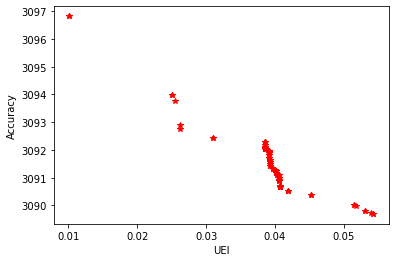

In [114]:
plt.plot(reposCost[:,1], reposCost[:,0],'r*')
plt.ylabel('Accuracy')
plt.xlabel('UEI')
plt.draw()
plt.pause(0.0000000001)

In [115]:
##print the highest UEI

uei = []
for idx,prt in enumerate(repos):
    uei.append(prt.cost[1])
print("Particle with the highest UEI of {} is in index {}:".format(repos[np.argmax(uei)].cost[1],np.argmax(uei)))
print(repos[np.argmax(uei)].cost)

best_w = repos[np.argmax(uei)].position.ravel()[:2]
best_b = repos[np.argmax(uei)].position.ravel()[-2]
y_pred = feedforward(Xtrain.T,best_w,best_b).T
best_ba,best_us = evaluate(y_train,y_pred.ravel(),Xtrain[:,-1])
print("Train:")
print(best_ba,best_us)
print("Test:")
y_pred = feedforward(Xtest.T,best_w,best_b).T
best_ba,best_us = evaluate(y_test,y_pred.ravel(),Xtest[:,-1])
print(best_ba,best_us)

Particle with the highest UEI of 0.05428634443584918 is in index 76:
[3089.7002, 0.05428634443584918]
Train:
3089.7002 0.05428634443584918
Test:
1323.5797 0.06626427387795052


In [120]:
##print the lowest UEI

uei = []
for idx,prt in enumerate(repos):
    uei.append(prt.cost[1])
print("Particle with the highest UEI of {} is in index {}:".format(repos[np.argmin(uei)].cost[1],np.argmin(uei)))
print(repos[np.argmin(uei)].cost)

best_w = repos[np.argmin(uei)].position.ravel()[:2]
best_b = repos[np.argmin(uei)].position.ravel()[-2]
y_pred = feedforward(Xtrain.T,best_w,best_b).T
best_ba,best_us = evaluate(y_train,y_pred.ravel(),Xtrain[:,-1])
print("Train:")
print(best_ba/Xtrain.shape[0],best_us)
print("Test:")
y_pred = feedforward(Xtest.T,best_w,best_b).T
best_ba,best_us = evaluate(y_test,y_pred.ravel(),Xtest[:,-1])
print(best_ba/Xtest.shape[0],best_us)

Particle with the highest UEI of 0.009509314905313438 is in index 53:
[3101.4958, 0.009509314905313438]
Train:
0.6142792334342196 0.009509314905313438
Test:
0.6138039815783776 0.016584609665465076


In [122]:
y_pred = feedforward(Xtest.T,best_w,best_b).T
print("US_S_0")
def underestimation_score(y_true,y_pred,SA):

    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] =np.round(y_pred)
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',0)
    Bias_FX0 = P_dash_FX0/P_FX0

    if P_FX0 == 0:
        print("Divsion by zero detected!")

    return Bias_FX0
print(underestimation_score(y_test,y_pred.ravel(),Xtest[:,-1]))
print("US_S_1")
def underestimation_score(y_true,y_pred,SA):

    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = np.round(y_pred)
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',1)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',1)
    Bias_FX0 = P_dash_FX0/P_FX0

    if P_FX0 == 0:
        print("Divsion by zero detected!")

    return Bias_FX0
print(underestimation_score(y_test,y_pred.ravel(),Xtest[:,-1]))

US_S_0
0.9419263456090652
US_S_1
1.0148148148148148


In [118]:
def get_ece(predicted_posterior, predicted_label, true_label, R):
    bin_size = 1/R
    total_sample = len(true_label)
    K = predicted_posterior.shape[1]

    score = 0
    for k in range(K):
        posteriors = predicted_posterior[:,k]
        sorted_indx = np.argsort(posteriors)
        for r in range(R):        
            indx = sorted_indx[r*R:(r+1)*R]
            predicted_label_ = predicted_label[indx]
            true_label_ = true_label[indx]

            indx_k = np.where(true_label_ == k)[0]
            acc = (
                np.nan_to_num(np.mean(predicted_label[indx_k] == k))
                if indx_k.size != 0
                else 0
            )
            conf = np.nan_to_num(np.mean(posteriors[indx_k])) if indx_k.size != 0 else 0
            score += len(indx) * np.abs(acc - conf)

    score /= (K*total_sample)
    return score
print("Acc: ",accuracy_score(y_test,np.round(y_pred)))

df = {}
df['sa'] = Xtest[:,-1]
df['actual'] = y_test
df['Run1'] = y_pred.ravel()
df = pd.DataFrame(df)

print("ECE overall:")
print(get_ece(df['Run1'].values.reshape(-1,1), np.round(df['Run1'].values.reshape(-1,1)), np.array(y_test), R=5))

minority = df[df['sa'] == 1]
majority = df[df['sa'] == 0]
print("ECE majority:")
print(get_ece(majority['Run1'].values.reshape(-1,1), np.round(majority['Run1'].values.reshape(-1,1)), np.array(majority.actual), R=5))
print("ECE minority:")
print(get_ece(minority['Run1'].values.reshape(-1,1), np.round(minority['Run1'].values.reshape(-1,1)), np.array(minority.actual), R=5))

Acc:  0.6651270207852193
ECE overall:
0.0069812821184549205
ECE majority:
0.010261273402896901
ECE minority:
0.014121357952213002


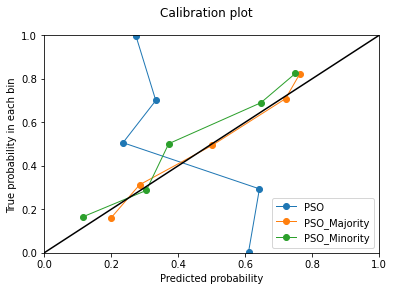

In [119]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_prob_lowuei, n_bins=5)
prob_true_maj, prob_pred_maj = calibration_curve(np.array(majority.actual), majority['Run1'].values.reshape(-1,1), n_bins=5)
prob_true_min, prob_pred_min = calibration_curve(np.array(minority.actual), minority['Run1'].values.reshape(-1,1), n_bins=5)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(prob_true, prob_pred, marker='o', linewidth=1, label='PSO')
plt.plot(prob_true_maj, prob_pred_maj, marker='o', linewidth=1, label='PSO_Majority')
plt.plot(prob_true_min, prob_pred_min, marker='o', linewidth=1, label='PSO_Minority')

# plt.plot(prob_true_dnn, prob_pred_dnn, marker='x', linewidth=1, label='Point Estimate')
# plt.plot(prob_true_dnn_maj, prob_pre_dnnd_maj, marker='x', linewidth=1, label='Dropout(0.2)')
# plt.plot(prob_true_dnn_min, prob_pred_dnn_min, marker='x', linewidth=1, label='Dropout(0.2)')


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

plt.legend()
plt.show()